In [ ]:
'''
import appropriate packages
'''
import math
import pandas as pd
import numpy as np
from operator import itemgetter

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
import sklearn.metrics as metrics

from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, r2_score, mean_squared_error

from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import GradientBoostingRegressor 

from sklearn.preprocessing import OneHotEncoder

from statsmodels.stats.outliers_influence import variance_inflation_factor


import warnings
warnings.filterwarnings("ignore")

In [ ]:
'''
alter display parameters for ease of viewing
'''
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
'''
load in file and distinguish target variable (CAP HIT)
'''

INFILE = "/content/Final_Project_Data_Forwards_standard.csv"

TARGET_A = "CAP HIT"

df = pd.read_csv( INFILE )

# Data Cleaning

In [ ]:
'''
data cleaning
'''
# check data types
df.dtypes

# drop rows with NA values
df = df.dropna()

# convert salary to integer using string manipulation and astype command
df['SALARY'] = df['SALARY'].str.replace(',', '')
df['SALARY'] = df['SALARY'].str.replace('$', '')
df['SALARY'] = df['SALARY'].astype(int)

# convert cap hit to integer using string manipulation and astype command
df['CAP HIT'] = df['CAP HIT'].str.replace(',', '')
df['CAP HIT'] = df['CAP HIT'].str.replace('$', '')
df['CAP HIT'] = df['CAP HIT'].astype(int)

# one hot encode handedness
df['HANDED_L'] = df.HANDED.str.count('Left')
df['HANDED_R'] = df.HANDED.str.count('Right')

# remove dollar signs and commas from SA and SF variables then convert to int
df['SA'] = df['SA'].str.replace(',', '')
df['SA'] = df['SA'].str.replace('$', '')
df['SA'] = df['SA'].astype(int)
df['SF'] = df['SF'].str.replace(',', '')
df['SF'] = df['SF'].str.replace('$', '')
df['SF'] = df['SF'].astype(int)


# convert TOI to seconds
# split TOI by ':' to minutes and seconds columns
df[['minutes', 'seconds']] = df['TOI'].str.split(pat = ':', expand = True)

# convert minutes and seconds columns to integers
df['minutes'] = df['minutes'].astype(int)
df['seconds'] = df['seconds'].astype(int)

# multiply minutes by 60 then add to seconds for total TOI in seconds
df['TOI_S'] = df['minutes']*60 + df['seconds']

# create avg TOI in minutes variable
df['TOI_M'] = df['minutes'] + df['seconds']/60

# create total minutes played during the season
df['Tot_MinPlayed'] = df['TOI_M'] * df['GP']

# drop original 'POS', 'HANDED', 'PLAYER', 'TOI', 'minutes', 'seconds', 'TYPE' columns
df = df.drop(columns = ['HANDED', 'PLAYER', 'TOI', 'minutes', 'seconds','TYPE']).reset_index(drop=True)

df.head(10)

PLAYER_clean  AGE    POS  GP   G   A    P  P/GP  +/-   Sh  Sh%   ixG  \
0   Connor McDavid   24      C  80  44  79  123  1.54   28  314 0.14 45.55   
1   Artemi Panarin   29     LW  75  22  74   96  1.28   21  177 0.12 18.48   
2  Auston Matthews   23      C  73  60  46  106  1.45   20  348 0.17 40.69   
3     John Tavares   30      C  79  27  49   76  0.96   -8  237 0.11 34.61   
4  Mitchell Marner   24     RW  72  35  62   97  1.35   23  224 0.16 26.52   
5   Jonathan Toews   33      C  71  12  25   37  0.52  -14  125 0.10 12.87   
6     Patrick Kane   32     RW  78  26  66   92  1.18  -19  287 0.09 23.85   
7      Jack Eichel   24      C  34  14  11   25  0.74    3  133 0.11 11.28   
8     Anze Kopitar   33      C  81  19  48   67  0.83   -6  210 0.09 20.58   
9     Tyler Seguin   29  C, RW  81  24  25   49  0.60  -21  218 0.11 21.72   

   iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60    SF   SA   SF%       CF  \
0  315  481  393   1.55  10.71  16.35  13.36  1310  790 62.38 2,259.00   
1  177  370  265   0.77   7.37  15.40  11.03   872  671 56.51 1,600.00   
2  348  599  484   1.62  13.88  23.89  19.30  1083  638 62.93 1,955.00   
3  237  429  347   1.45   9.96  18.03  14.58   976  714 57.75 1,781.00   
4  224  420  315   1.06   8.94  16.76  12.57  1002  710 58.53 1,845.00   
5  125  188  158   0.62   6.04   9.09   7.64   639  677 48.56 1,191.00   
6  287  514  371   0.84  10.11  18.12  13.08  1023  785 56.58 1,789.00   
7  133  193  160   1.03  12.10  17.55  14.56   421  312 57.44   741.00   
8  210  353  280   0.73   7.49  12.59   9.99  1032  774 57.14 1,855.00   
9  218  345  280   0.90   9.06  14.34  11.64   829  755 52.34 1,478.00   

        CA   CF%       FF       FA   FF%    xGF   xGA  xGF%   CAP HIT  \
0 1,361.00 62.40 1,746.00 1,067.00 62.07 157.93 76.54 67.36  12500000   
1 1,226.00 56.62 1,229.00   939.00 56.69  95.23 62.67 60.31  11642857   
2 1,103.00 63.93 1,520.00   861.00 63.84 123.18 60.11 67.20  11640250   
3 1,211.00 59.53 1,383.00   936.00 59.64 110.93 61.71 64.26  11000000   
4 1,227.00 60.06 1,430.00   962.00 59.78 119.57 69.66 63.19  10903000   
5 1,198.00 49.85   875.00   903.00 49.21  62.49 62.13 50.14  10500000   
6 1,409.00 55.94 1,328.00 1,047.00 55.92  90.38 79.59 53.17  10500000   
7   567.00 56.65   556.00   411.00 57.50  39.86 32.84 54.83  10000000   
8 1,394.00 57.09 1,410.00 1,039.00 57.57 107.03 83.76 56.10  10000000   
9 1,351.00 52.24 1,105.00 1,026.00 51.85  87.01 72.97 54.39   9850000   

     SALARY  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  
0  13000000         1         0   1323  22.05       1,764.00  
1  13000000         0         1   1152  19.20       1,440.00  
2  10470000         1         0   1236  20.60       1,503.80  
3   9350000         1         0   1084  18.07       1,427.27  
4  10358000         0         1   1252  20.87       1,502.40  
5   6900000         1         0   1048  17.47       1,240.13  
6   6900000         1         0   1309  21.82       1,701.70  
7  10000000         0         1   1163  19.38         659.03  
8   8000000         1         0   1246  20.77       1,682.10  
9  13000000         0         1   1069  17.82       1,443.15

In [ ]:
duplicateRows = df[df.duplicated(['PLAYER_clean'])]
duplicateRows

PLAYER_clean  AGE     POS  GP   G   A   P  P/GP  +/-   Sh  Sh%   ixG  \
224  Evander Kane   29  LW, RW  43  22  17  39  0.91   25  152 0.14 19.25   

     iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60   SF   SA   SF%     CF     CA  \
224  152  260  206   1.38  10.90  18.64  14.78  550  414 57.05 977.00 750.00   

      CF%     FF     FA   FF%   xGF   xGA  xGF%  CAP HIT   SALARY  HANDED_L  \
224 56.57 745.00 582.00 56.14 60.85 41.48 59.46  2108696  1375000         1   

     HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  
224         0   1167  19.45         836.35

In [ ]:
df = df.drop([df.index[224]])

duplicateRows = df[df.duplicated(['PLAYER_clean'])]
duplicateRows

Empty DataFrame
Columns: [PLAYER_clean, AGE, POS, GP, G, A, P, P/GP, +/-, Sh, Sh%, ixG, iSh, iCF, iFF, ixG60, iSh60, iCF60, iFF60, SF, SA, SF%, CF, CA, CF%, FF, FA, FF%, xGF, xGA, xGF%, CAP HIT, SALARY, HANDED_L, HANDED_R, TOI_S, TOI_M, Tot_MinPlayed]
Index: []

# EDA

<AxesSubplot:xlabel='GP'>

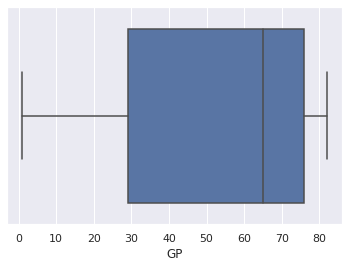

In [ ]:
sns.boxplot(x="GP", data=df)

<AxesSubplot:xlabel='GP', ylabel='Count'>

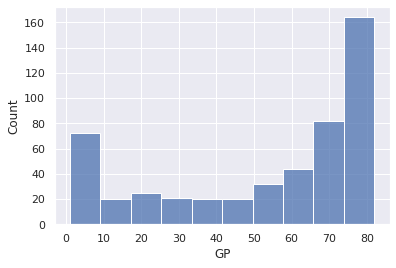

In [ ]:
sns.histplot(x="GP", data=df)

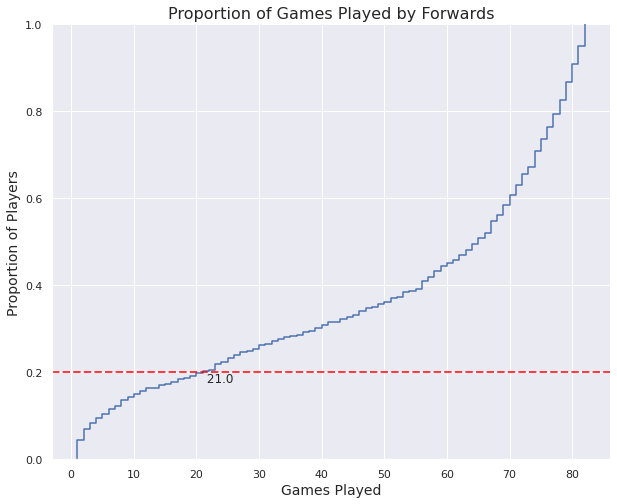

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="GP")
sns.set(style = "white", color_codes = True)
y_special = 0.2
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='red', lw=2, alpha=0.75)
plt.xlabel('Games Played', fontsize = 14)
plt.ylabel('Proportion of Players', fontsize = 14)
ax.set_title('Proportion of Games Played by Forwards', fontdict={'fontsize':16, 'fontweight': 'medium'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.savefig('PropGPFwds.jpeg', bbox_inches='tight')

In [ ]:
df['GP'].describe()

count   500.00
mean     52.79
std      27.69
min       1.00
25%      29.00
50%      65.00
75%      76.00
max      82.00
Name: GP, dtype: float64

<AxesSubplot:xlabel='CAP HIT', ylabel='Count'>

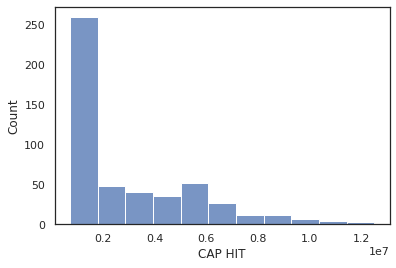

In [ ]:
sns.histplot(x="CAP HIT", data = df)

In [ ]:
# drop players with less than 21 games played (lower 20%) which is about 1/4 of the season
df = df[df['GP']>=21]

<AxesSubplot:xlabel='P/GP', ylabel='Count'>

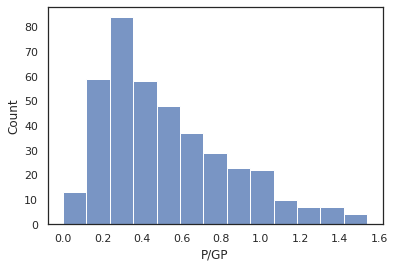

In [ ]:
sns.histplot(x="P/GP", data = df)

<AxesSubplot:xlabel='TOI_M', ylabel='Count'>

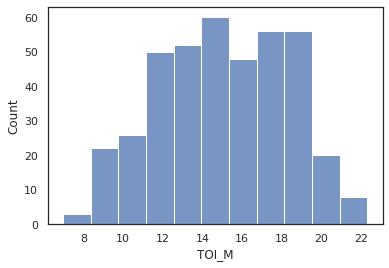

In [ ]:
sns.histplot(x="TOI_M", data = df)

In [ ]:
df['CAP HIT'].value_counts()

750000      51
725000      14
1000000     11
5500000     11
6000000     11
1500000     10
5000000      9
2000000      8
7000000      8
900000       7
800000       7
3500000      7
4500000      6
2750000      6
3000000      6
5250000      6
2500000      5
825000       5
850000       4
6500000      4
9500000      4
4750000      4
2300000      4
975000       4
8000000      4
3250000      4
1100000      4
1400000      3
5900000      3
5875000      3
4000000      3
1250000      3
1750000      3
1050000      3
2250000      3
950000       3
7500000      3
3400000      3
874125       3
5300000      3
2100000      2
4250000      2
4450000      2
2200000      2
5350000      2
4900000      2
1700000      2
3200000      2
1550000      2
3100000      2
10000000     2
5400000      2
1450000      2
7142857      2
1175000      2
1200000      2
6125000      2
8250000      2
758333       2
6750000      2
1350000      2
8500000      2
9000000      2
2800000      2
737500       2
10500000     2
2533333   

In [ ]:
df_min_caphit = df[df['CAP HIT'] <= 750000]
df_no_min_caphit = df[df['CAP HIT'] > 750000]

In [ ]:
len(df_no_min_caphit)

334

In [ ]:
len(df_min_caphit)

67

In [ ]:
len(df)

401

In [ ]:
len(df_min_caphit)/len(df)

0.16708229426433915

<AxesSubplot:xlabel='TOI_M', ylabel='Count'>

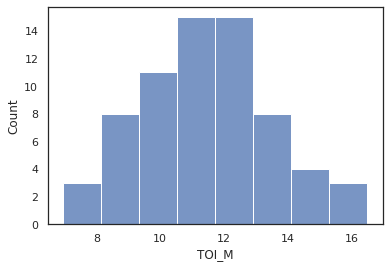

In [ ]:
sns.histplot(x="TOI_M", data = df_min_caphit)

<AxesSubplot:xlabel='TOI_M', ylabel='Count'>

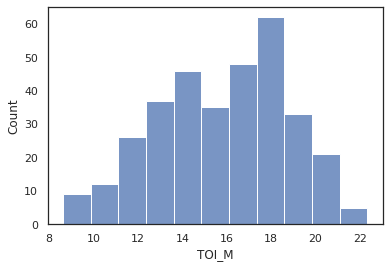

In [ ]:
sns.histplot(x="TOI_M", data = df_no_min_caphit)

<AxesSubplot:xlabel='CAP HIT', ylabel='Count'>

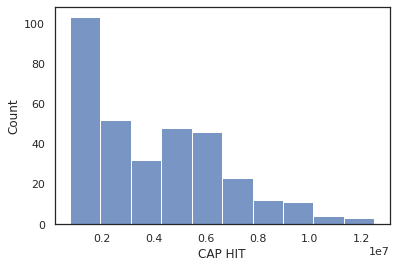

In [ ]:
sns.histplot(x="CAP HIT", data = df_no_min_caphit)

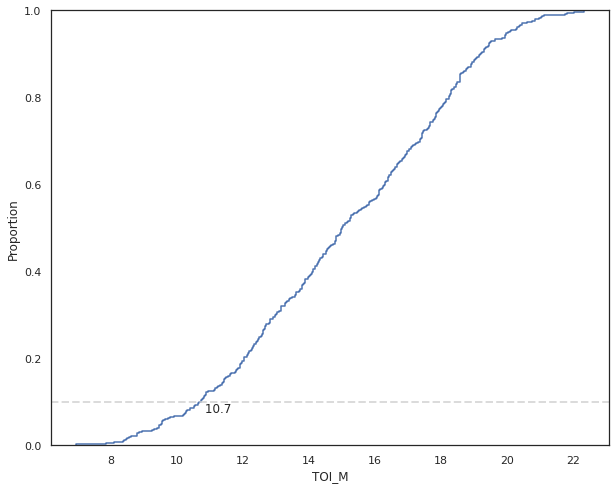

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="TOI_M")
y_special = 0.1
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='#cfcfcf', lw=2, alpha=0.75)
plt.show()

In [ ]:
# df = df[df['TOI_M'] >= 12.5]

<AxesSubplot:xlabel='P/GP', ylabel='Count'>

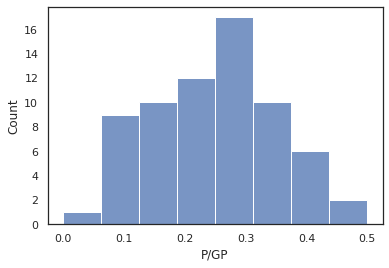

In [ ]:
sns.histplot(x="P/GP", data = df_min_caphit)

<AxesSubplot:xlabel='P/GP', ylabel='Count'>

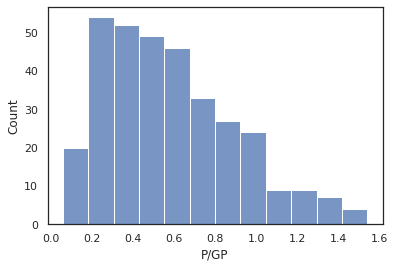

In [ ]:
sns.histplot(x="P/GP", data = df_no_min_caphit)

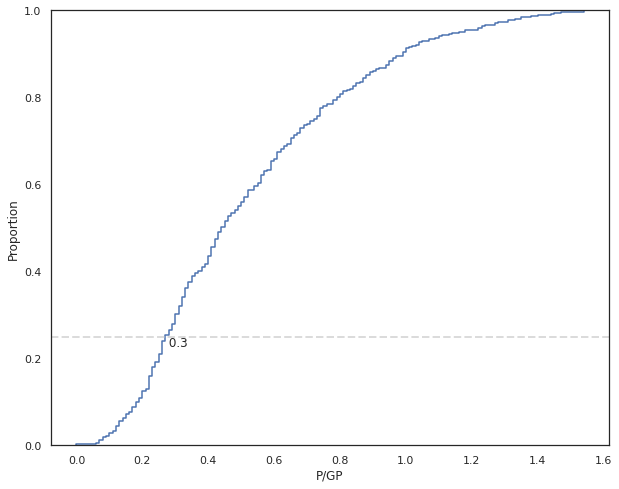

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="P/GP")
y_special = 0.25
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='#cfcfcf', lw=2, alpha=0.75)
plt.show()

In [ ]:
# df = df[df['P/GP'] >= 0.3]

<AxesSubplot:xlabel='TOI_M', ylabel='Count'>

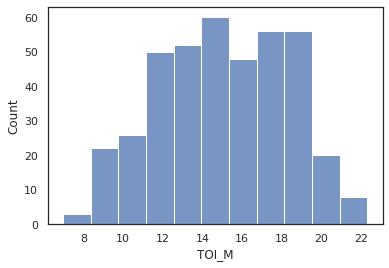

In [ ]:
sns.histplot(x="TOI_M", data = df)

<AxesSubplot:xlabel='Tot_MinPlayed', ylabel='Count'>

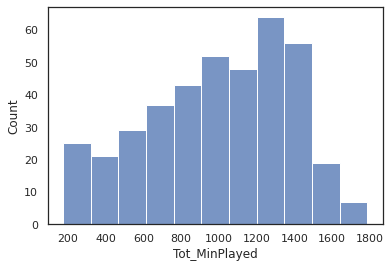

In [ ]:
sns.histplot(x="Tot_MinPlayed", data = df)

<AxesSubplot:xlabel='Tot_MinPlayed'>

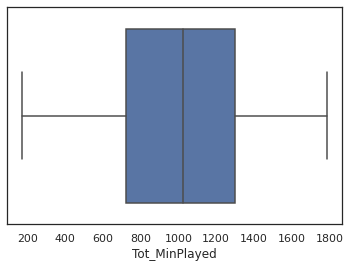

In [ ]:
sns.boxplot(x="Tot_MinPlayed", data = df)

<AxesSubplot:xlabel='Tot_MinPlayed', ylabel='Count'>

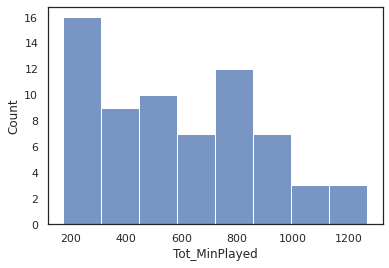

In [ ]:
sns.histplot(x="Tot_MinPlayed", data = df_min_caphit)

<AxesSubplot:xlabel='Tot_MinPlayed'>

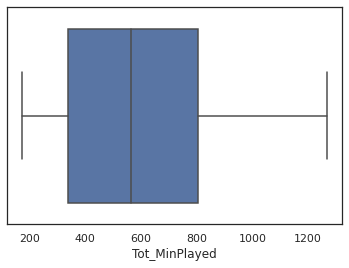

In [ ]:
sns.boxplot(x="Tot_MinPlayed", data = df_min_caphit)

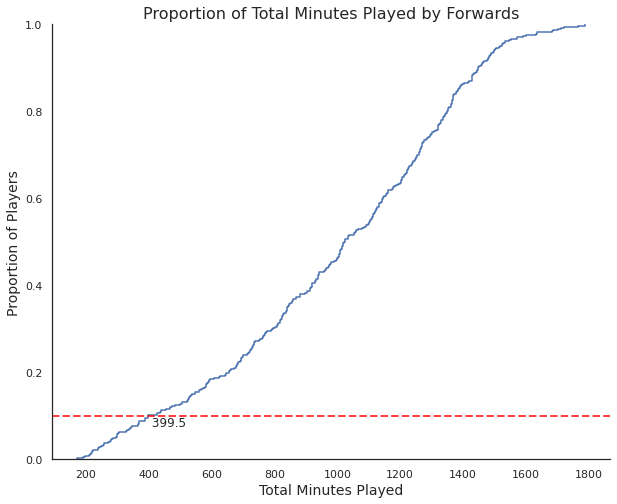

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="Tot_MinPlayed")
y_special = 0.1
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='red', lw=2, alpha=0.75)
plt.xlabel('Total Minutes Played', fontsize = 14)
plt.ylabel('Proportion of Players', fontsize = 14)
ax.set_title('Proportion of Total Minutes Played by Forwards', fontdict={'fontsize':16, 'fontweight': 'medium'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.savefig('PropMinFwds.jpeg', bbox_inches='tight')

In [ ]:
# drop players with less than 400 total minutes played during the season
df = df[df['Tot_MinPlayed']>=400]
len(df.index)

360

<AxesSubplot:xlabel='CAP HIT', ylabel='Count'>

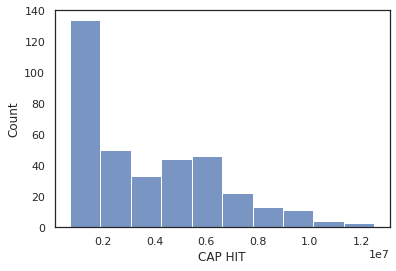

In [ ]:
sns.histplot(x="CAP HIT", data = df)

In [ ]:
# check POS values
df['POS'].value_counts()

LW, RW       67
C            52
RW, LW       52
RW           38
C, LW        32
LW           30
C, RW        30
LW, C        22
RW, C        18
C, LW, RW     7
LW, C, RW     6
LW, RW, C     4
C, RW, LW     1
RW, C, LW     1
Name: POS, dtype: int64

In [ ]:
# convert POS values to be consistent for different position combinations
df['POS'].replace(['RW, LW'], 'LW, RW', regex=True, inplace=True)
df['POS'].replace(['LW, C'], 'C, LW', regex=True, inplace=True)
df['POS'].replace(['RW, C'], 'C, RW', regex=True, inplace=True)
df['POS'].replace(['RW, C, LW'], 'C, LW, RW', regex=True, inplace=True)
df['POS'].replace(['C, RW, LW'], 'C, LW, RW', regex=True, inplace=True)

df = df[df['POS'] != 'LW, LD']

df['POS'].value_counts()

LW, RW       119
C, LW         54
C             52
C, RW         48
RW            38
LW            30
C, LW, RW     15
LW, C, RW      4
Name: POS, dtype: int64

In [ ]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()

#perform one-hot encoding on 'POS' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['POS']]).toarray())

encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
df = df.reset_index(drop=True)
df = df.join(encoder_df)

In [ ]:
# create stats by game played
df['G/GP'] = df['G']/df['GP']
df['A/GP'] = df['A']/df['GP']
df['plusminus/GP'] = df['+/-']/df['GP']
df['Sh/GP'] = df['Sh']/df['GP']

# create stats by minute played
df['G/Min'] = df['G']/df['Tot_MinPlayed']
df['A/Min'] = df['A']/df['Tot_MinPlayed']
df['plusminus/Min'] = df['+/-']/df['Tot_MinPlayed']
df['Sh/Min'] = df['Sh']/df['Tot_MinPlayed']

# drop variables not needed for modeling
model_df = df.drop(columns = ['PLAYER_clean', 'POS', 'GP', 'G', 'A', 'P', '+/-', 'Sh', 'SALARY'])

model_df.head()

AGE  P/GP  Sh%   ixG  iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60    SF   SA  \
0   24  1.54 0.14 45.55  315  481  393   1.55  10.71  16.35  13.36  1310  790   
1   29  1.28 0.12 18.48  177  370  265   0.77   7.37  15.40  11.03   872  671   
2   23  1.45 0.17 40.69  348  599  484   1.62  13.88  23.89  19.30  1083  638   
3   30  0.96 0.11 34.61  237  429  347   1.45   9.96  18.03  14.58   976  714   
4   24  1.35 0.16 26.52  224  420  315   1.06   8.94  16.76  12.57  1002  710   

    SF%       CF       CA   CF%       FF       FA   FF%    xGF   xGA  xGF%  \
0 62.38 2,259.00 1,361.00 62.40 1,746.00 1,067.00 62.07 157.93 76.54 67.36   
1 56.51 1,600.00 1,226.00 56.62 1,229.00   939.00 56.69  95.23 62.67 60.31   
2 62.93 1,955.00 1,103.00 63.93 1,520.00   861.00 63.84 123.18 60.11 67.20   
3 57.75 1,781.00 1,211.00 59.53 1,383.00   936.00 59.64 110.93 61.71 64.26   
4 58.53 1,845.00 1,227.00 60.06 1,430.00   962.00 59.78 119.57 69.66 63.19   

    CAP HIT  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  POS_C  \
0  12500000         1         0   1323  22.05       1,764.00   1.00   
1  11642857         0         1   1152  19.20       1,440.00   0.00   
2  11640250         1         0   1236  20.60       1,503.80   1.00   
3  11000000         1         0   1084  18.07       1,427.27   1.00   
4  10903000         0         1   1252  20.87       1,502.40   0.00   

   POS_C, LW  POS_C, LW, RW  POS_C, RW  POS_LW  POS_LW, C, RW  POS_LW, RW  \
0       0.00           0.00       0.00    0.00           0.00        0.00   
1       0.00           0.00       0.00    1.00           0.00        0.00   
2       0.00           0.00       0.00    0.00           0.00        0.00   
3       0.00           0.00       0.00    0.00           0.00        0.00   
4       0.00           0.00       0.00    0.00           0.00        0.00   

   POS_RW  G/GP  A/GP  plusminus/GP  Sh/GP  G/Min  A/Min  plusminus/Min  \
0    0.00  0.55  0.99          0.35   3.92   0.02   0.04           0.02   
1    0.00  0.29  0.99          0.28   2.36   0.02   0.05           0.01   
2    0.00  0.82  0.63          0.27   4.77   0.04   0.03           0.01   
3    0.00  0.34  0.62         -0.10   3.00   0.02   0.03          -0.01   
4    1.00  0.49  0.86          0.32   3.11   0.02   0.04           0.02   

   Sh/Min  
0    0.18  
1    0.12  
2    0.23  
3    0.17  
4    0.15

## Correlation Matrix Heatmap

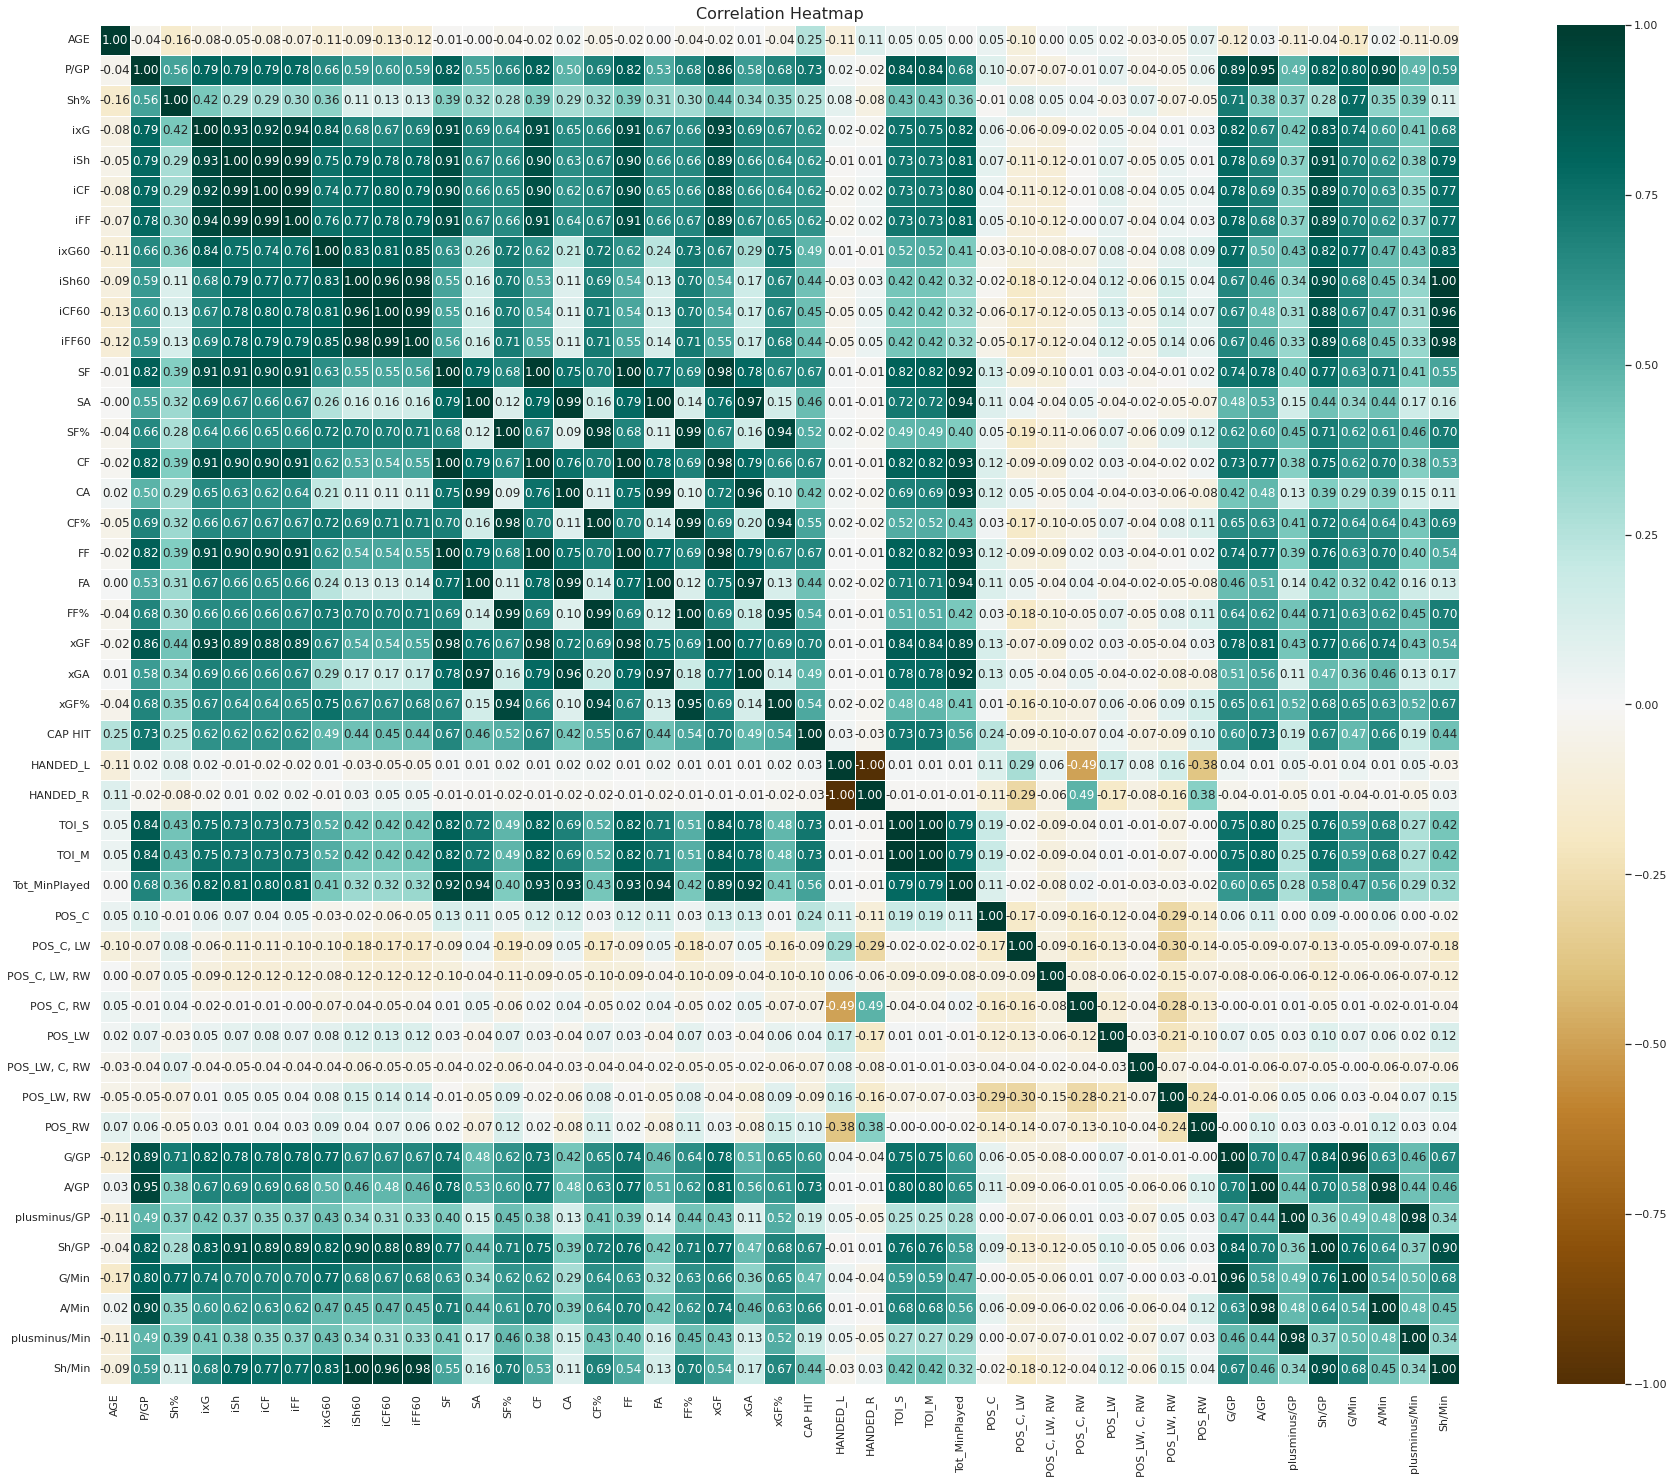

In [ ]:
# creating correlation heatmap to determine potential predictor variables
corr_mat = model_df.corr()
f, ax = plt.subplots(figsize=(35, 25))
sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, square=True, linewidths=.5, cmap='BrBG', fmt='.2f')
plt.title('Correlation Heatmap', size = 16)

plt.savefig('CorrHeatmap.pdf', bbox_inches='tight')
plt.savefig('CorrHeatmap.jpeg', bbox_inches='tight')

## Scatterplots

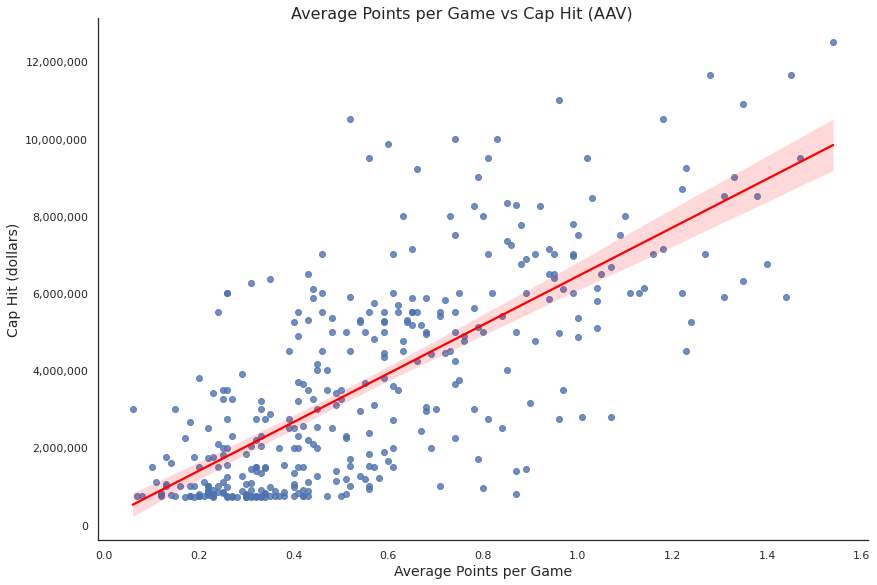

In [ ]:
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib import pyplot as plt

sns.set(style = "white", color_codes = True)
p = sns.lmplot(x='P/GP', y='CAP HIT', data=model_df, height=8.27, aspect=11.7/8.27, line_kws={'color': 'red'})
plt.ticklabel_format(style='plain', axis='y')
#p.set(title='AVG Points per Game vs Cap Hit (AAV)')
p.fig.suptitle("Average Points per Game vs Cap Hit (AAV)", fontsize=16, fontdict={"weight": "bold"})
p.set_axis_labels( "Average Points per Game" , "Cap Hit (dollars)" , size = 14)


for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))


plt.savefig('PGPvsCAPHIT.pdf', bbox_inches='tight')
plt.savefig('PGPvsCAPHIT.jpeg', bbox_inches='tight')

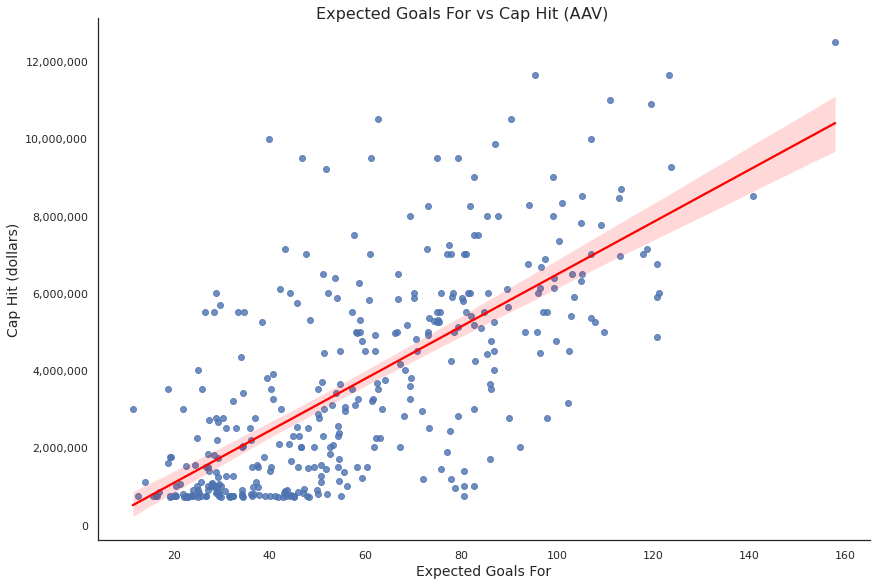

In [ ]:
p =sns.lmplot(x='xGF', y='CAP HIT', data=model_df, height=8.27, aspect=11.7/8.27, line_kws={'color': 'red'})

plt.ticklabel_format(style='plain', axis='y')
#p.set(title='Expected Goals For vs Cap Hit (AAV)')
p.fig.suptitle("Expected Goals For vs Cap Hit (AAV)", fontsize=16, fontdict={"weight": "bold"})
p.set_axis_labels( "Expected Goals For" , "Cap Hit (dollars)" , size = 14)


for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

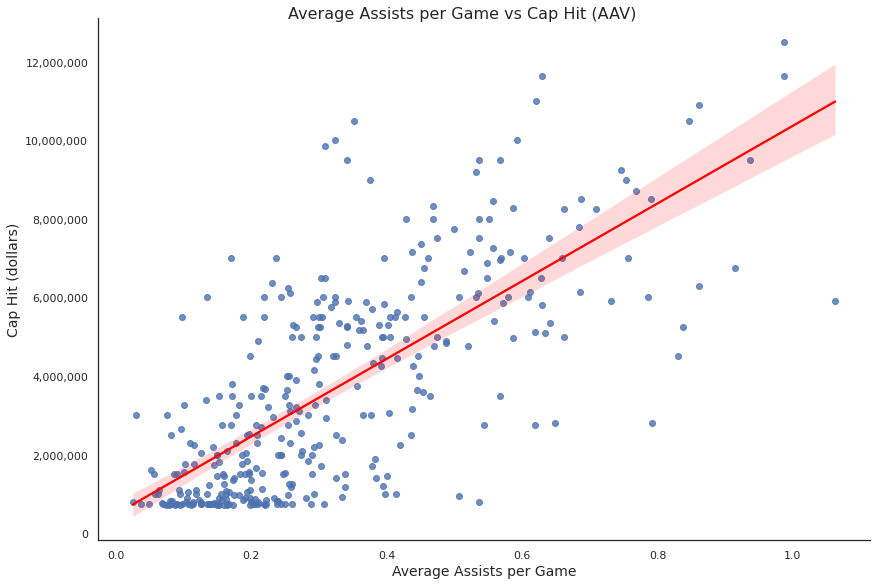

In [ ]:
p =sns.lmplot(x='A/GP', y='CAP HIT', data=model_df, height=8.27, aspect=11.7/8.27, line_kws={'color': 'red'})

plt.ticklabel_format(style='plain', axis='y')
#p.set(title='AVG Assists per Game vs Cap Hit (AAV)')
p.fig.suptitle("Average Assists per Game vs Cap Hit (AAV)", fontsize=16, fontdict={"weight": "bold"})
p.set_axis_labels( "Average Assists per Game" , "Cap Hit (dollars)" , size = 14)


for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

# Forward Models

## Regression Models

### Feature Selection

In [ ]:
# the independent variables set
X = model_df.drop([TARGET_A, 'HANDED_L', 'HANDED_R', 'POS_C', 'POS_C, LW', 'POS_C, LW, RW', 'POS_C, RW', 'POS_LW', 'POS_LW, C, RW','POS_LW, RW', 'POS_RW',
                  'TOI_S' ,'TOI_M'], axis=1 )

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data = vif_data.sort_values(by=['VIF'], ascending=False)  
print(vif_data)

len(vif_data)

          feature        VIF
31         Sh/Min 309,642.01
8           iSh60 309,013.89
19            FF%  72,854.68
1            P/GP  56,460.17
16            CF%  33,433.68
13            SF%  27,178.65
18             FA  23,658.91
17             FF  22,807.44
25           A/GP  20,470.76
6             iFF  16,042.96
10          iFF60  13,887.34
14             CF  11,397.93
24           G/GP  11,265.74
15             CA   9,773.61
12             SA   9,397.37
11             SF   8,897.82
5             iCF   8,858.48
9           iCF60   7,806.11
4             iSh   4,715.95
22           xGF%   3,152.14
23  Tot_MinPlayed   1,327.35
20            xGF   1,113.23
3             ixG   1,063.57
28          G/Min     970.27
7           ixG60     940.67
21            xGA     845.55
27          Sh/GP     706.75
29          A/Min     431.82
2             Sh%     141.75
0             AGE      68.29
26   plusminus/GP      55.02
30  plusminus/Min      54.78


32

In [ ]:
# split data into X and Y for test and training
# X = X.drop([TARGET_A, 'HANDED_L', 'POS_C'], axis=1 )

Y = df[ [TARGET_A] ]

In [ ]:
# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression
from numpy import array 

select = SelectKBest(score_func=r_regression, k=10)
z = select.fit_transform(X,Y)

In [ ]:
# diplay selected variables
filter = select.get_support()
print(X.columns[filter])

Index(['P/GP', 'iSh', 'iCF', 'SF', 'CF', 'FF', 'xGF', 'A/GP', 'Sh/GP',
       'A/Min'],
      dtype='object')


In [ ]:
select2 = SelectKBest(score_func=f_regression, k=10)
f = select2.fit_transform(X,Y)

# diplay selected variables
filter2 = select2.get_support()
print(X.columns[filter2])

Index(['P/GP', 'iSh', 'iCF', 'SF', 'CF', 'FF', 'xGF', 'A/GP', 'Sh/GP',
       'A/Min'],
      dtype='object')


In [ ]:
select3 = SelectKBest(score_func=mutual_info_regression, k=10)
m = select3.fit_transform(X,Y)

# diplay selected variables
filter3 = select3.get_support()
print(X.columns[filter3])

Index(['P/GP', 'iSh', 'iFF', 'SF', 'CF', 'FF', 'xGF', 'A/GP', 'Sh/GP',
       'A/Min'],
      dtype='object')


In [ ]:
# reduced set of final predictor varaibles to use in model
X_red = X[['P/GP', 'CF',
       'A/Min']]


#        Coefficients
# ---------
# Total Variables:  4
# INTERCEPT  =  -499823.93511570804
# CF  =  1639.1391192642009
# G/GP  =  980175.9962894581
# A/GP  =  6591390.122000143

In [ ]:
# check VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_red.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_red.values, i)
                          for i in range(len(X_red.columns))]
vif_data = vif_data.sort_values(by=['VIF'], ascending=False)  
print(vif_data)

  feature   VIF
0    P/GP 27.03
2   A/Min 22.85
1      CF 12.82


### Train/Test Split

In [ ]:
'''
create training and test data sets
'''
# setting random state to 2 for now so we can repeat results
X_train, X_test, Y_train, Y_test = train_test_split(X_red, Y, train_size = 0.8, test_size = 0.2, random_state = 2)

# checking shapes of data sets to ensure it split correctly
#print( "FLAG DATA" )
#print( "TRAINING = ", X_train.shape )
#print( "TEST = ", X_test.shape )

# A_train, A_test, B_train, B_test = train_test_split(A, B, train_size = 0.8, test_size = 0.2, random_state = 2)

In [ ]:
'''
define function to get accuracy scores and coefficents from linear models
'''
# calculates accuracy scores for linear model
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

# prints accuracy scores
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

# grabs coefficents from linear models 
def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nCoefficients")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

### Multiple Linear Regression

In [ ]:
'''
regression with SelectKBest feature selection
'''
WHO = "REG_KBEST"

# amount lost given loan defaults (linear regression)
AMT = LinearRegression()
AMT = AMT.fit( X_train, Y_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, X_train, Y_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, X_test, Y_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )

# call function from above to grab coefficents
REG_KBEST_AMT_COEF = getCoefLinear( AMT, X_train )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(X_train, Y_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(X_test, Y_test[TARGET_A]))

# save results for comparison with other models
REG_KBEST_AMT = TEST_AMT.copy()


y_pred_mlr = AMT.predict(X_test)
rmse_mlr = math.sqrt(np.round(mean_squared_error(Y_test, y_pred_mlr), 2))
r2_mlr = np.round(r2_score(Y_test, y_pred_mlr), 3)

REG_KBEST RMSE ACCURACY
REG_KBEST_Train  =  1812498.1756630468
REG_KBEST  =  1852131.1571156275
------



Coefficients
---------
Total Variables:  4
INTERCEPT  =  -596124.222239269
P/GP  =  4175872.19728536
CF  =  1511.5997487635668
A/Min  =  12826147.309631113
Training R Squared :  0.5503099066234369
Test R Squared :  0.5390289839640985


### Ridge Regression

In [ ]:
# Ridge regression
from sklearn.linear_model import Ridge

WHO = "RIDGE"

ridge = Ridge()
ridge = ridge.fit(X_train, Y_train[TARGET_A])
                          
TRAIN_ridge = getAmtAccuracyScores( WHO + "_Train", ridge, X_train, Y_train[TARGET_A] )
TEST_ridge = getAmtAccuracyScores( WHO, ridge, X_test, Y_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_ridge, TEST_ridge ] )

varNames = list( X_train.columns.values )

# call function from above to grab coefficents
RIDGE_COEF = getCoefLinear( ridge, X_train )

# print R squared vale of model on training data
print('Training R Squared : ', ridge.score(X_train, Y_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', ridge.score(X_test, Y_test[TARGET_A]))

# save results for comparison with other models
REG_RIDGE_AMT = TEST_ridge.copy()

# create table of results
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = math.sqrt(np.round(mean_squared_error(Y_test, y_pred_ridge), 2))
r2_ridge = np.round(r2_score(Y_test, y_pred_ridge), 3)

df_results = pd.DataFrame([[rmse_mlr, r2_mlr], [rmse_ridge, r2_ridge]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression', 'Ridge Regression'])

df_results

RIDGE RMSE ACCURACY
RIDGE_Train  =  1814851.7985765967
RIDGE  =  1866009.0443358463
------



Coefficients
---------
Total Variables:  4
INTERCEPT  =  -560741.1622027135
P/GP  =  4122552.0661707204
CF  =  1739.3441240205568
A/Min  =  177004.93434862542
Training R Squared :  0.5491412565070037
Test R Squared :  0.5320950570452859


RMSE  R-Squared
Linear Regression 1,852,131.16       0.54
Ridge Regression  1,866,009.04       0.53

## Random Forest Models

In [ ]:
''' define functions to get accuracy scores and variables based on weight from RF and GB models '''

# calculates accuracy scores (RMSE)
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

# define function to extract variables and weights
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

### Random Forest Train/Test Split

In [ ]:
''' create new test and train data set with all variables for RF and GB models '''

W = model_df.copy()
W = W.drop( [TARGET_A,  'HANDED_L', 'HANDED_R', 'POS_C, LW', 'POS_C, LW, RW', 'POS_C, RW', 'POS_LW', 'POS_LW, C, RW','POS_LW, RW', 'POS_RW', 'POS_C',
                    'TOI_S', 'TOI_M', 'Tot_MinPlayed'], axis=1 )

Z = model_df[ [TARGET_A] ]

W_train, W_test, Z_train, Z_test = train_test_split(W, Z, train_size=0.8, test_size=0.2, random_state=2)

### Random Forest

In [ ]:
''' create RF model '''

WHO = "RF"

# create random forest regressor and fit to data
AMT = RandomForestRegressor(n_estimators = 100, random_state=2)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by RF
feature_cols = list( W.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by RF and their weights
for i in vars_RF_amt :
    print( i )

# save results for comparison with other models later
RF_AMT = TEST_AMT.copy()

# add results to table
y_pred_rf = AMT.predict(W_test)
rmse_rf = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_rf), 2))
r2_rf = np.round(r2_score(Z_test, y_pred_rf), 3)


df_rf = pd.DataFrame([[rmse_rf, r2_rf]],
                           columns = ['RMSE', 'R-Squared'], index = ['Random Forest'])

df_results = df_results.append(df_rf)

df_results

RF RMSE ACCURACY
RF_Train  =  636704.192829608
RF  =  1615601.3818450165
------


('A/GP', 100)
('P/GP', 24)
('AGE', 17)
('xGF', 17)
('CF', 11)


RMSE  R-Squared
Linear Regression 1,852,131.16       0.54
Ridge Regression  1,866,009.04       0.53
Random Forest     1,615,601.38       0.65

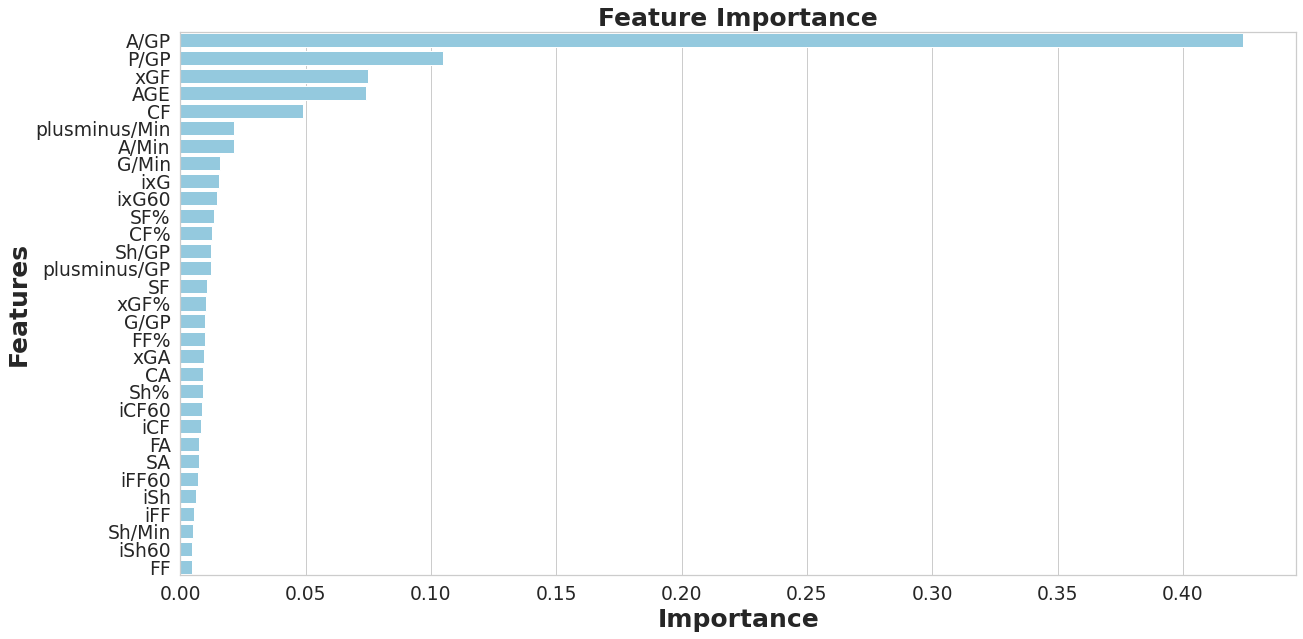

None

Features  Gini-Importance
0            A/GP             0.42
1            P/GP             0.10
2             xGF             0.07
3             AGE             0.07
4              CF             0.05
5   plusminus/Min             0.02
6           A/Min             0.02
7           G/Min             0.02
8             ixG             0.02
9           ixG60             0.01
10            SF%             0.01
11            CF%             0.01
12          Sh/GP             0.01
13   plusminus/GP             0.01
14             SF             0.01
15           xGF%             0.01
16           G/GP             0.01
17            FF%             0.01
18            xGA             0.01
19             CA             0.01
20            Sh%             0.01
21          iCF60             0.01
22            iCF             0.01
23             FA             0.01
24             SA             0.01
25          iFF60             0.01
26            iSh             0.01
27            iFF             0.01
28         Sh/Min             0.00
29          iSh60             0.00
30             FF             0.00

In [ ]:
# get feature importance
feats = {}
for feature, importance in zip(W_train.columns, AMT.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### Grandient Boosted Machine

In [ ]:
''' create GB model '''

WHO = "GB"

# create gradient boosting regressor and fit to data
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by GB
feature_cols = list( W.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by GB and their weights
for i in vars_GB_amt :
    print( i )

# save results for comparison with other models later on
GB_CLM = TEST_AMT.copy()

# add results to table
y_pred_gb = AMT.predict(W_test)
rmse_gb = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_gb), 2))
r2_gb = np.round(r2_score(Z_test, y_pred_gb), 3)


df_gb = pd.DataFrame([[rmse_gb, r2_gb]],
                           columns = ['RMSE', 'R-Squared'], index = ['Gradient Boosted RF'])

df_results = df_results.append(df_gb)

df_results

GB RMSE ACCURACY
GB_Train  =  548408.1000011445
GB  =  1646485.0539172923
------


('A/GP', 100)
('AGE', 21)
('CF', 15)
('P/GP', 14)
('xGF', 8)


RMSE  R-Squared
Linear Regression   1,852,131.16       0.54
Ridge Regression    1,866,009.04       0.53
Random Forest       1,615,601.38       0.65
Gradient Boosted RF 1,646,485.05       0.64

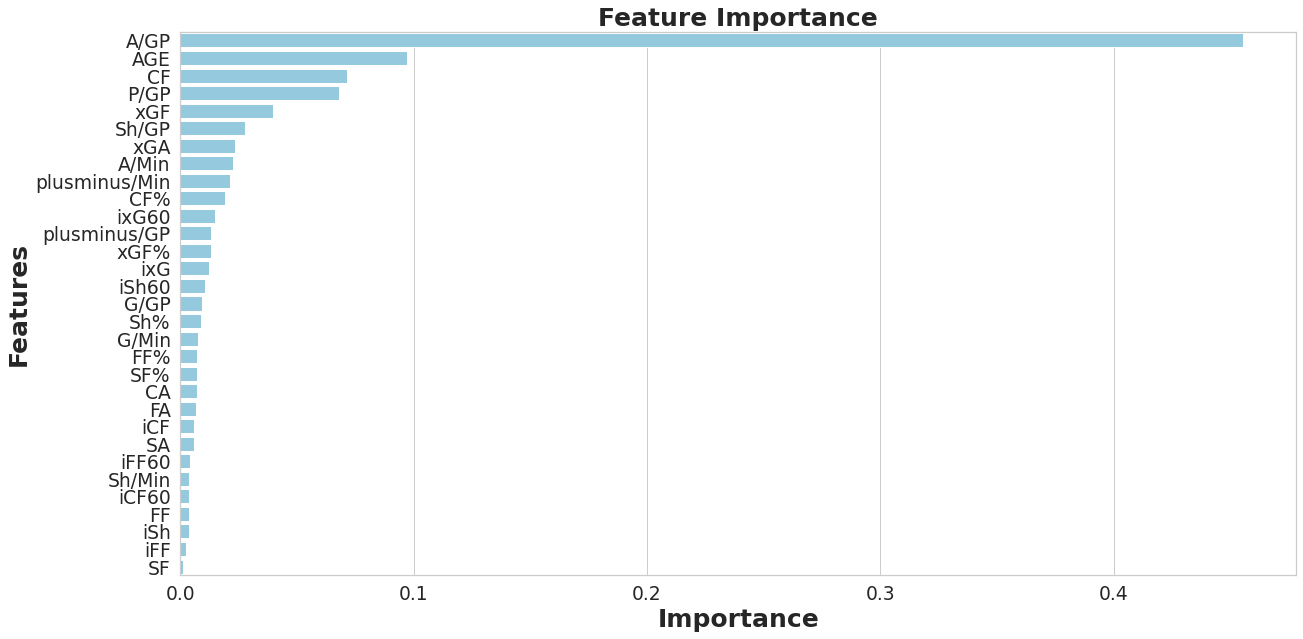

None

Features  Gini-Importance
0            A/GP             0.46
1             AGE             0.10
2              CF             0.07
3            P/GP             0.07
4             xGF             0.04
5           Sh/GP             0.03
6             xGA             0.02
7           A/Min             0.02
8   plusminus/Min             0.02
9             CF%             0.02
10          ixG60             0.01
11   plusminus/GP             0.01
12           xGF%             0.01
13            ixG             0.01
14          iSh60             0.01
15           G/GP             0.01
16            Sh%             0.01
17          G/Min             0.01
18            FF%             0.01
19            SF%             0.01
20             CA             0.01
21             FA             0.01
22            iCF             0.01
23             SA             0.01
24          iFF60             0.00
25         Sh/Min             0.00
26          iCF60             0.00
27             FF             0.00
28            iSh             0.00
29            iFF             0.00
30             SF             0.00

In [ ]:
# get feature importance
feats = {}
for feature, importance in zip(W_train.columns, AMT.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

### Regression with RF/GB variables

In [ ]:
''' run regression with RF/GB variables '''

WHO = "REG_RF_VARS"


# since RF variables are extracted with weights attached, need to run through loop that only takes variable names
print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )

# create regression model with vars selected by RF and GB models
AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# call function from above to grab coefficents
REG_RF_AMT_COEF = getCoefLinear( AMT, W_train[RF_amt] )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(W_train[RF_amt], Z_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(W_test[RF_amt], Z_test[TARGET_A]))

# save results for comparison with other models
REG_RF_AMT = TEST_AMT.copy()

# add results to table
y_pred_mlr2 = AMT.predict(W_test[RF_amt])
rmse_mlr2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_mlr2), 2))
r2_mlr2 = np.round(r2_score(Z_test, y_pred_mlr2), 3)


df_mlr2 = pd.DataFrame([[rmse_mlr2, r2_mlr2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression with RF Variables'])

df_results = df_results.append(df_mlr2)

df_results




('A/GP', 100)
('P/GP', 24)
('AGE', 17)
('xGF', 17)
('CF', 11)
REG_RF_VARS RMSE ACCURACY
REG_RF_VARS_Train  =  1642391.4182526905
REG_RF_VARS  =  1648004.3449075904
------



Coefficients
---------
Total Variables:  6
INTERCEPT  =  -5564025.594538646
A/GP  =  3327767.234194934
P/GP  =  2051809.5554345073
AGE  =  201646.12175135687
xGF  =  38715.37225738843
CF  =  -699.7704205869231
Training R Squared :  0.6307576568909523
Test R Squared :  0.6350386712980671


RMSE  R-Squared
Linear Regression                   1,852,131.16       0.54
Ridge Regression                    1,866,009.04       0.53
Random Forest                       1,615,601.38       0.65
Gradient Boosted RF                 1,646,485.05       0.64
Linear Regression with RF Variables 1,648,004.34       0.64

### Regression with RF Variabales (reduced)

In [ ]:
# create regression model with vars selected by RF and GB models
# remove CF since has negative coefficient and lowest weight
Red_amt = ['P/GP', 'A/GP', 'AGE', 'xGF']

AMT = LinearRegression()
AMT = AMT.fit( W_train[Red_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[Red_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[Red_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# call function from above to grab coefficents
REG_RF_AMT_COEF = getCoefLinear( AMT, W_train[Red_amt] )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(W_train[Red_amt], Z_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(W_test[Red_amt], Z_test[TARGET_A]))

# save results for comparison with other models
REG_RF_AMT2 = TEST_AMT.copy()

y_pred_mlr2 = AMT.predict(W_test[Red_amt])
rmse_mlr2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_mlr2), 2))
r2_mlr2 = np.round(r2_score(Z_test, y_pred_mlr2), 3)


df_mlr2 = pd.DataFrame([[rmse_mlr2, r2_mlr2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression with RF Variables (Reduced)'])

df_results = df_results.append(df_mlr2)

df_results

REG_RF_VARS RMSE ACCURACY
REG_RF_VARS_Train  =  1643354.113343973
REG_RF_VARS  =  1652445.094949736
------



Coefficients
---------
Total Variables:  5
INTERCEPT  =  -5713540.937923204
P/GP  =  2149993.655720073
A/GP  =  3328038.4398001838
AGE  =  201815.54823843366
xGF  =  27524.53072239179
Training R Squared :  0.6303246639189086
Test R Squared :  0.6330691550997166


RMSE  R-Squared
Linear Regression                             1,852,131.16       0.54
Ridge Regression                              1,866,009.04       0.53
Random Forest                                 1,615,601.38       0.65
Gradient Boosted RF                           1,646,485.05       0.64
Linear Regression with RF Variables           1,648,004.34       0.64
Linear Regression with RF Variables (Reduced) 1,652,445.09       0.63

### RF Hyperparameter Tuning

In [ ]:
# hyperparameter tuning using randomizedsearchCV
# from sklearn.model_selection import RandomizedSearchCV

# AMT = RandomForestRegressor(random_state=2)
# AMT = AMT.fit( W_train, Z_train[TARGET_A] )

# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# max_features = ['log2', 'sqrt']
# max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
# min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
# min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
# #bootstrap = [True, False]
# param_dist = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
# rs = RandomizedSearchCV(AMT, 
#                         param_dist, 
#                         n_iter = 100, 
#                         cv = 3, 
#                         verbose = 1, 
#                         n_jobs=-1, 
#                         random_state=2)

# rs.fit(W_train, Z_train[TARGET_A])
# rs.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'log2',
#  'max_depth': 12}

In [ ]:
# get dataframe of RandomSearchCV results
# rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
# rs_df = rs_df.drop([
#             'mean_fit_time', 
#             'std_fit_time', 
#             'mean_score_time',
#             'std_score_time', 
#             'params', 
#             'split0_test_score', 
#             'split1_test_score', 
#             'split2_test_score', 
#             'std_test_score'],
#             axis=1)
# rs_df.head(10)

In [ ]:
# create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average

# fig, axs = plt.subplots(ncols=3, nrows=2)
# sns.set(style="whitegrid", color_codes=True, font_scale = 2)
# fig.set_size_inches(24,18)

# sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
# axs[0,0].set_title(label = 'n_estimators', weight='bold')

# sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
# axs[0,1].set_title(label = 'min_samples_split', weight='bold')

# sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
# axs[0,2].set_title(label = 'min_samples_leaf', weight='bold')

# sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
# axs[1,0].set_title(label = 'max_features', weight='bold')

# sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
# axs[1,1].set_title(label = 'max_depth', weight='bold')

# plt.show()

In [ ]:
# fine tune hyperparameters using gridsearchCV
# from sklearn.model_selection import GridSearchCV

# AMT = RandomForestRegressor(random_state=2)
# AMT = AMT.fit( W_train, Z_train[TARGET_A] )

# n_estimators = [100, 200, 700]
# max_features = ['sqrt']
# max_depth = [5,6,11,12,14,15]
# min_samples_split = [2,3,6,7,23]
# min_samples_leaf = [2,3,5,6,7]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
# gs = GridSearchCV(AMT, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(W_train, Z_train[TARGET_A])
# rf_ht = gs.best_estimator_
# gs.best_params_

# Fitting 3 folds for each of 450 candidates, totalling 1350 fits
# {'max_depth': 11,
#  'max_features': 'sqrt',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 100}

In [ ]:
WHO = "RF_HT"

# create RF regressor and fit to data
AMT = RandomForestRegressor(random_state=2, max_depth=11,
                                max_features= 'sqrt',
                                min_samples_leaf= 2,
                                min_samples_split=2,
                                n_estimators= 100)

AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by RF
feature_cols = list( W.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by RF and their weights
for i in vars_RF_amt :
    print( i )

# save results for comparison with other models later on
RF_HT = TEST_AMT.copy()

y_pred_rf2 = AMT.predict(W_test)
rmse_rf2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_rf2), 2))
r2_rf2 = np.round(r2_score(Z_test, y_pred_rf2), 3)


df_rf2 = pd.DataFrame([[rmse_rf2, r2_rf2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Random Forest (Hyperparameter Tuning)'])

df_results = df_results.append(df_rf2)

df_results

RF_HT RMSE ACCURACY
RF_HT_Train  =  827840.4977086962
RF_HT  =  1685450.5521349262
------


('A/GP', 100)
('P/GP', 96)
('CF', 87)
('A/Min', 71)
('xGF', 62)
('FF', 52)
('Sh/GP', 41)
('AGE', 32)


RMSE  R-Squared
Linear Regression                             1,852,131.16       0.54
Ridge Regression                              1,866,009.04       0.53
Random Forest                                 1,615,601.38       0.65
Gradient Boosted RF                           1,646,485.05       0.64
Linear Regression with RF Variables           1,648,004.34       0.64
Linear Regression with RF Variables (Reduced) 1,652,445.09       0.63
Random Forest (Hyperparameter Tuning)         1,685,450.55       0.62

### RF with PCA Transformation

In [ ]:
from sklearn.preprocessing import StandardScaler
 
ss = StandardScaler()
 
# separate the independent and dependent variables
# X_data = model_df.drop(columns = ['CAP HIT'])
# target = model_df['CAP HIT']
 
# standardization of dependent variables 

X_train_scaled = ss.fit_transform(W_train)
X_test_scaled = ss.transform(W_test)
y_train = np.array(Z_train)
y_test = np.array(Z_test)

In [ ]:
# create baseline RF

rf2 = RandomForestRegressor(random_state=2)
rf2 = rf2.fit(X_train_scaled, y_train)
rf2.score(X_train_scaled, y_train)

0.9445395806722592

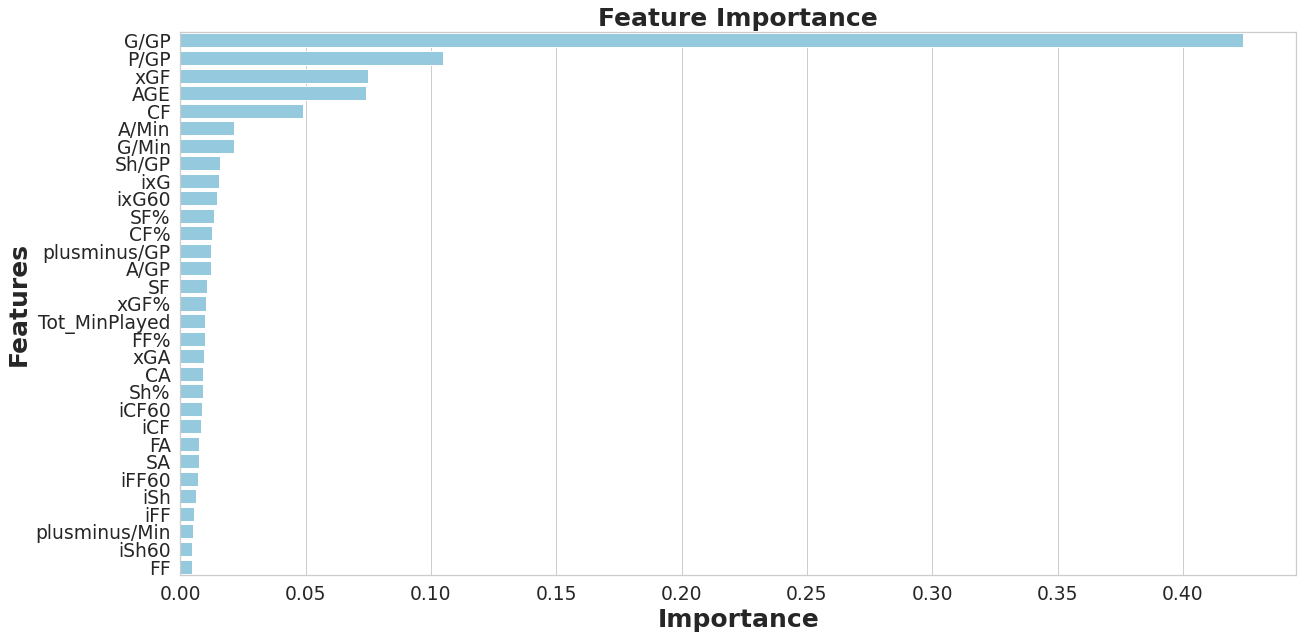

None

Features  Gini-Importance
0            G/GP             0.42
1            P/GP             0.10
2             xGF             0.07
3             AGE             0.07
4              CF             0.05
5           A/Min             0.02
6           G/Min             0.02
7           Sh/GP             0.02
8             ixG             0.02
9           ixG60             0.01
10            SF%             0.01
11            CF%             0.01
12   plusminus/GP             0.01
13           A/GP             0.01
14             SF             0.01
15           xGF%             0.01
16  Tot_MinPlayed             0.01
17            FF%             0.01
18            xGA             0.01
19             CA             0.01
20            Sh%             0.01
21          iCF60             0.01
22            iCF             0.01
23             FA             0.01
24             SA             0.01
25          iFF60             0.01
26            iSh             0.01
27            iFF             0.01
28  plusminus/Min             0.00
29          iSh60             0.00
30             FF             0.00

In [ ]:
# get feature importance
feats = {}
for feature, importance in zip(X.columns, rf2.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

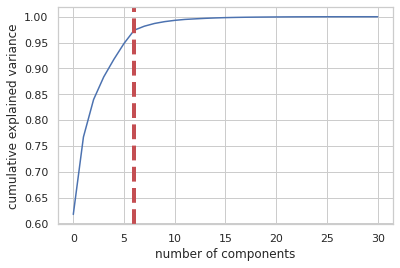

None

Cumulative Variance Ratio  Explained Variance Ratio
0                        0.62                      0.62
1                        0.77                      0.15
2                        0.84                      0.07
3                        0.88                      0.04
4                        0.92                      0.03
5                        0.95                      0.03
6                        0.97                      0.03
7                        0.98                      0.01
8                        0.99                      0.01
9                        0.99                      0.00
10                       0.99                      0.00
11                       0.99                      0.00
12                       1.00                      0.00
13                       1.00                      0.00
14                       1.00                      0.00

In [ ]:
# create plot to determine number of compenents to use for PCA
from sklearn.decomposition import PCA

pca_test = PCA(n_components=31)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

# based on the below output I chose 6 components since that explains about 97% of the variance and there isn't a drastic improvement after that

In [ ]:
# PCA transformation
pca = PCA(n_components=6)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
# display table of components
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=W.columns, index=pca_dims)
pca_test_df.head(6).T

PCA Component 0  PCA Component 1  PCA Component 2  \
AGE                      -0.02            -0.06            -0.02   
P/GP                      0.21            -0.04             0.15   
Sh%                       0.10            -0.09             0.37   
ixG                       0.22            -0.06            -0.06   
iSh                       0.22            -0.03            -0.17   
iCF                       0.22            -0.03            -0.17   
iFF                       0.22            -0.03            -0.16   
ixG60                     0.19             0.16            -0.07   
iSh60                     0.17             0.23            -0.24   
iCF60                     0.17             0.23            -0.24   
iFF60                     0.18             0.23            -0.23   
SF                        0.21            -0.13             0.00   
SA                        0.14            -0.35            -0.08   
SF%                       0.18             0.20             0.11   
CF                        0.21            -0.14             0.00   
CA                        0.13            -0.36            -0.08   
CF%                       0.18             0.18             0.11   
FF                        0.21            -0.13             0.01   
FA                        0.14            -0.36            -0.08   
FF%                       0.18             0.19             0.11   
xGF                       0.21            -0.13             0.04   
xGA                       0.14            -0.34            -0.08   
xGF%                      0.18             0.19             0.17   
G/GP                      0.20             0.00             0.09   
A/GP                      0.19            -0.06             0.17   
plusminus/GP              0.12             0.09             0.39   
Sh/GP                     0.21             0.08            -0.16   
G/Min                     0.19             0.06             0.12   
A/Min                     0.17            -0.02             0.22   
plusminus/Min             0.12             0.08             0.40   
Sh/Min                    0.17             0.23            -0.24   

               PCA Component 3  PCA Component 4  PCA Component 5  
AGE                       0.42             0.21             0.71  
P/GP                     -0.03            -0.12             0.24  
Sh%                      -0.36            -0.39             0.12  
ixG                      -0.05             0.02            -0.08  
iSh                      -0.02             0.09            -0.02  
iCF                      -0.02             0.05            -0.03  
iFF                      -0.03             0.07            -0.04  
ixG60                    -0.13            -0.00            -0.02  
iSh60                    -0.10             0.11             0.08  
iCF60                    -0.10             0.04             0.06  
iFF60                    -0.11             0.07             0.05  
SF                        0.13             0.00            -0.10  
SA                       -0.03             0.07            -0.06  
SF%                       0.28            -0.12            -0.17  
CF                        0.14            -0.02            -0.12  
CA                       -0.02             0.10            -0.08  
CF%                       0.27            -0.17            -0.16  
FF                        0.14            -0.01            -0.11  
FA                       -0.03             0.08            -0.07  
FF%                       0.28            -0.15            -0.17  
xGF                       0.11            -0.02            -0.06  
xGA                      -0.01            -0.01            -0.02  
xGF%                      0.22            -0.08            -0.16  
G/GP                     -0.26            -0.20             0.18  
A/GP                      0.14            -0.05             0.26  
plusminus/GP             -0.15             0.54            -0.07  
Sh/GP                    -0.0

In [ ]:
# refit xgb random forest model using PCA transformation
rf3 = RandomForestRegressor(random_state=2)
rf3 = rf3.fit(X_train_scaled_pca, y_train)

In [ ]:
print('Training R Squared : ', rf3.score(X_train_scaled_pca, y_train))

Training R Squared :  0.944882001739936


In [ ]:
y_pred_pca = rf3.predict(X_test_scaled_pca)
rmse_pca = math.sqrt(np.round(mean_squared_error(y_test, y_pred_pca), 2))
r2_pca = np.round(r2_score(y_test, y_pred_pca), 3)


df_pca = pd.DataFrame([[rmse_pca, r2_pca]],
                           columns = ['RMSE', 'R-Squared'], index = ['RF with PCA'])

df_results = df_results.append(df_pca)

df_results

RMSE  R-Squared
Linear Regression                             1,852,131.16       0.54
Ridge Regression                              1,866,009.04       0.53
Random Forest                                 1,615,601.38       0.65
Gradient Boosted RF                           1,646,485.05       0.64
Linear Regression with RF Variables           1,648,004.34       0.64
Linear Regression with RF Variables (Reduced) 1,652,445.09       0.63
Random Forest (Hyperparameter Tuning)         1,685,450.55       0.62
RF with PCA                                   1,699,704.61       0.61

### RF PCA HyperParameter Tuning

In [ ]:
# hyperparameter tuning using randomizedsearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rf3, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=2)

rs.fit(X_train_scaled_pca, y_train)
rs.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 900,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'log2',
#  'max_depth': 13,
#  'bootstrap': False}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 12,
 'bootstrap': True}

In [ ]:
# get dataframe of RandomSearchCV results
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                300                       2                      2   
1                200                       2                      2   
2                900                       2                      2   
3                700                      12                      2   
4                200                       2                      7   
5                600                      23                      2   
6               1000                       7                      7   
7                700                       2                      7   
8                200                       2                      7   
9                900                      34                      2   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               log2              12            True             0.57   
1               log2              14            True             0.56   
2               log2              13           False             0.56   
3               log2              11            True             0.55   
4               log2              14           False             0.52   
5               log2               7           False             0.52   
6               log2               8            True             0.52   
7               sqrt              15            True             0.51   
8               log2               6            True             0.51   
9               log2              14           False             0.50   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

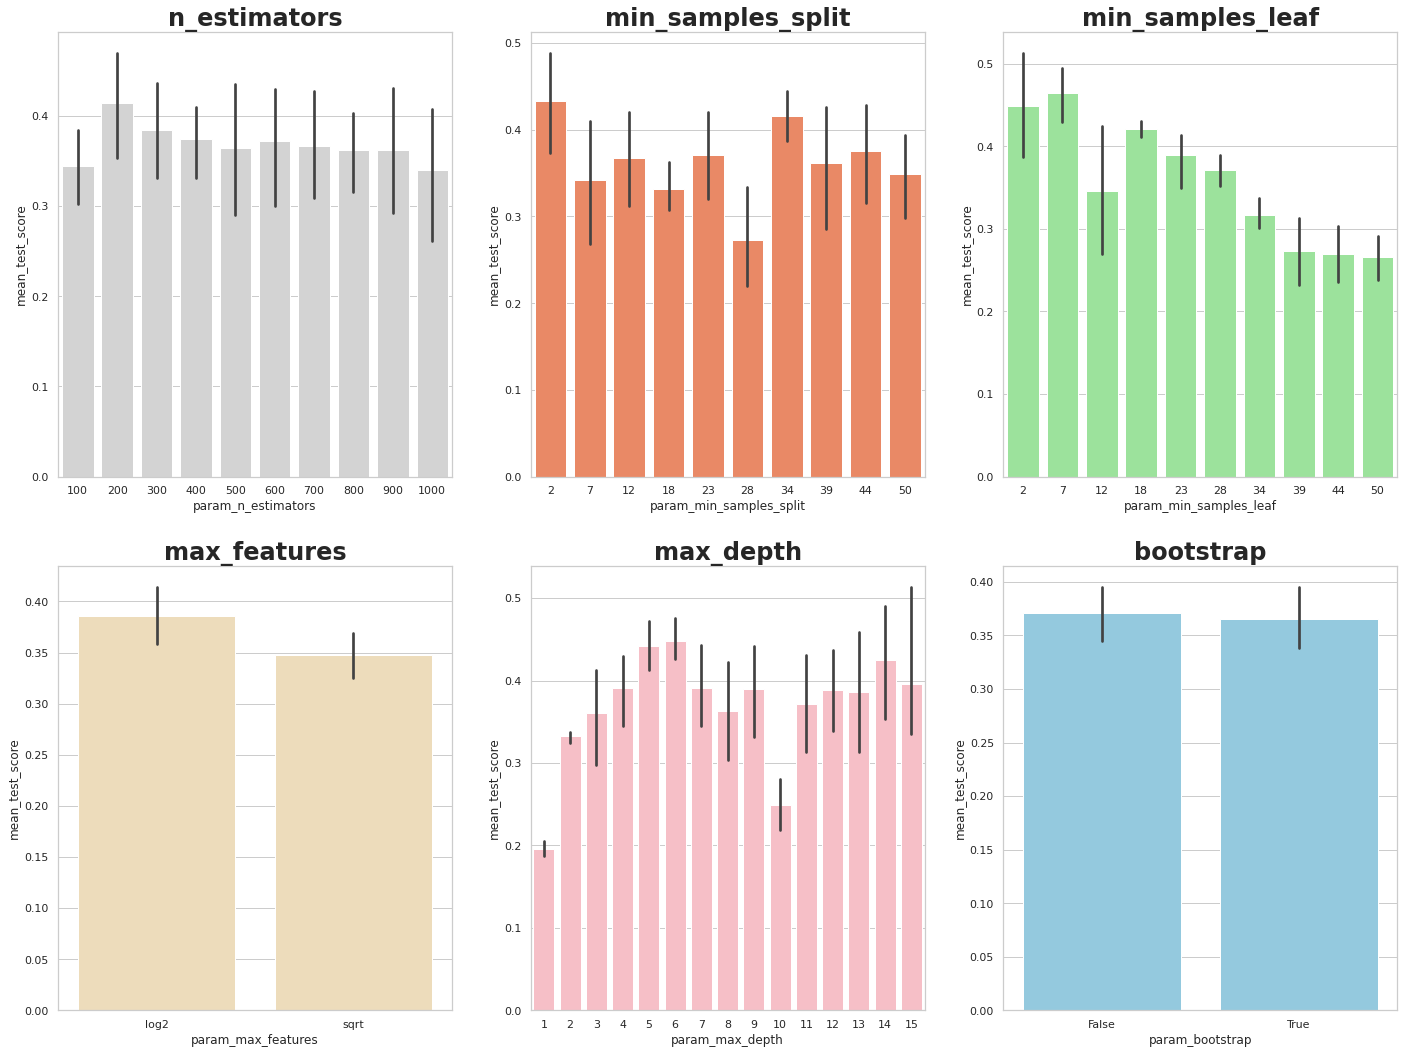

In [ ]:
# create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(24,18)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_title(label = 'n_estimators', weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_split', weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_title(label = 'min_samples_leaf', weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_title(label = 'max_depth', weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_title(label = 'bootstrap', weight='bold')

plt.show()

In [ ]:
''' this section is commented out because it takes a 5-10 to run, but it is used to fine tune the hyperparameters. I've hard-coded the results below and passed these parameters to the rf4 model'''

# fine tune hyperparameters using gridsearchCV
# from sklearn.model_selection import GridSearchCV

# n_estimators = [200, 300]
# max_features = ['log2']
# max_depth = [5,6,14]
# min_samples_split = [2,3,4,33,34,35]
# min_samples_leaf = [2,3,4,5,6,7]
# bootstrap = [False]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# gs = GridSearchCV(rf3, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train_scaled_pca, y_train)
# rf4 = gs.best_estimator_
# gs.best_params_

# Fitting 3 folds for each of 216 candidates, totalling 648 fits
# {'bootstrap': False,
#  'max_depth': 14,
#  'max_features': 'log2',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 200}

" this section is commented out because it takes a 5-10 to run, but it is used to fine tune the hyperparameters. I've hard-coded the results below and passed these parameters to the rf4 model"

In [ ]:
# tune hyperparameters using the results from the above gridsearchCV
rf4 = RandomForestRegressor(bootstrap=False, max_depth=14, max_features='log2',
                            min_samples_leaf=2, min_samples_split=2, n_estimators=200)
rf4 = rf4.fit(X_train_scaled_pca, y_train)

In [ ]:
y_pred_pca2 = rf4.predict(X_test_scaled_pca)
rmse_pca2 = math.sqrt(np.round(mean_squared_error(y_test, y_pred_pca2), 2))
r2_pca2 = np.round(r2_score(y_test, y_pred_pca2), 3)


df_pca2 = pd.DataFrame([[rmse_pca2, r2_pca2]],
                           columns = ['RMSE', 'R-Squared'], index = ['RF with PCA (Hyperparameter Tuning)'])

df_results = df_results.append(df_pca2)

df_results

RMSE  R-Squared
Linear Regression                             1,852,131.16       0.54
Ridge Regression                              1,866,009.04       0.53
Random Forest                                 1,615,601.38       0.65
Gradient Boosted RF                           1,646,485.05       0.64
Linear Regression with RF Variables           1,648,004.34       0.64
Linear Regression with RF Variables (Reduced) 1,652,445.09       0.63
Random Forest (Hyperparameter Tuning)         1,685,450.55       0.62
RF with PCA                                   1,699,704.61       0.61
RF with PCA (Hyperparameter Tuning)           1,684,539.58       0.62

## Final Forward Model Results

In [ ]:
Red_amt = ['P/GP', 'A/GP', 'AGE', 'xGF']

AMT = LinearRegression()
final_fwd = AMT.fit( W_train[Red_amt], Z_train[TARGET_A] )

# call function from above to grab coefficents
REG_RF_AMT_COEF = getCoefLinear( final_fwd, W_train[Red_amt] )


Coefficients
---------
Total Variables:  5
INTERCEPT  =  -5713540.937923204
P/GP  =  2149993.655720073
A/GP  =  3328038.4398001838
AGE  =  201815.54823843366
xGF  =  27524.53072239179


In [ ]:
# create predicted CAP HIT for all players
df['pred_cap'] = final_fwd.predict(W[Red_amt])

In [ ]:
# create residuals and abs residuals
df['residuals'] = df['CAP HIT'] - df['pred_cap']
df['residuals_abs'] = df['residuals'].abs()

In [ ]:
# format cap hit
#df['CAP HIT'] = df['CAP HIT'].map('{:,.0f}'.format)

# create list of 10 players with highest residual error
df[['PLAYER_clean', 'CAP HIT', 'pred_cap', 'residuals','residuals_abs']].sort_values(by = 'residuals_abs', ascending=False).head(10)

PLAYER_clean   CAP HIT     pred_cap     residuals  residuals_abs
7           Jack Eichel  10000000 2,894,873.64  7,105,126.36   7,105,126.36
5        Jonathan Toews  10500000 4,956,221.30  5,543,778.70   5,543,778.70
9          Tyler Seguin   9850000 4,851,187.93  4,998,812.07   4,998,812.07
63   Jesperi Kotkaniemi   6100035 1,287,249.21  4,812,785.79   4,812,785.79
10           Mark Stone   9500000 5,055,162.33  4,444,837.67   4,444,837.67
12           Jamie Benn   9500000 5,063,909.44  4,436,090.56   4,436,090.56
2       Auston Matthews  11640250 7,533,299.28  4,106,950.72   4,106,950.72
138         Nazem Kadri   4500000 8,570,308.46 -4,070,308.46   4,070,308.46
77   Jonathan Huberdeau   5900000 9,890,711.24 -3,990,711.24   3,990,711.24
289     Michael Bunting    950000 4,903,656.51 -3,953,656.51   3,953,656.51

In [ ]:
# subest dataframe to get players with highest abs residuals
df_hr = df.query('residuals_abs >=3953656.5').sort_values(by='residuals', ascending=False)
df_hr2 = df_hr[['PLAYER_clean', 'residuals']]
df_hr2

PLAYER_clean     residuals
7           Jack Eichel  7,105,126.36
5        Jonathan Toews  5,543,778.70
9          Tyler Seguin  4,998,812.07
63   Jesperi Kotkaniemi  4,812,785.79
10           Mark Stone  4,444,837.67
12           Jamie Benn  4,436,090.56
2       Auston Matthews  4,106,950.72
289     Michael Bunting -3,953,656.51
77   Jonathan Huberdeau -3,990,711.24
138         Nazem Kadri -4,070,308.46

In [ ]:
df_hr

PLAYER_clean  AGE     POS  GP   G   A    P  P/GP  +/-   Sh  Sh%  \
7           Jack Eichel   24       C  34  14  11   25  0.74    3  133 0.11   
5        Jonathan Toews   33       C  71  12  25   37  0.52  -14  125 0.10   
9          Tyler Seguin   29   C, RW  81  24  25   49  0.60  -21  218 0.11   
63   Jesperi Kotkaniemi   20       C  66  12  17   29  0.44    3   81 0.15   
10           Mark Stone   29      RW  37   9  21   30  0.81    7   71 0.13   
12           Jamie Benn   31   C, LW  82  18  28   46  0.56  -13  182 0.10   
2       Auston Matthews   23       C  73  60  46  106  1.45   20  348 0.17   
289     Michael Bunting   25      LW  79  23  40   63  0.80   27  175 0.13   
77   Jonathan Huberdeau   28  LW, RW  80  30  85  115  1.44   35  222 0.14   
138         Nazem Kadri   30       C  71  28  59   87  1.23   13  247 0.11   

      ixG  iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60    SF   SA   SF%  \
7   11.28  133  193  160   1.03  12.10  17.55  14.56   421  312 57.44   
5   12.87  125  188  158   0.62   6.04   9.09   7.64   639  677 48.56   
9   21.72  218  345  280   0.90   9.06  14.34  11.64   829  755 52.34   
63   9.67   81  146  111   0.73   6.12  11.04   8.39   467  336 58.16   
10  12.47   71  118   94   1.10   6.28  10.43   8.31   421  320 56.82   
12  23.12  182  317  250   1.01   7.95  13.85  10.92   735  769 48.87   
2   40.69  348  599  484   1.62  13.88  23.89  19.30  1083  638 62.93   
289 23.80  175  296  242   1.15   8.55  14.46  11.83   780  567 57.91   
77  28.36  222  344  280   1.09   8.57  13.28  10.81  1048  761 57.93   
138 30.63  247  439  339   1.35  10.85  19.28  14.89   997  603 62.31   

          CF       CA   CF%       FF       FA   FF%    xGF   xGA  xGF%  \
7     741.00   567.00 56.65   556.00   411.00 57.50  39.86 32.84 54.83   
5   1,191.00 1,198.00 49.85   875.00   903.00 49.21  62.49 62.13 50.14   
9   1,478.00 1,351.00 52.24 1,105.00 1,026.00 51.85  87.01 72.97 54.39   
63    889.00   581.00 60.48   664.00   455.00 59.34  42.19 33.54 55.70   
10    742.00   605.00 55.09   567.00   435.00 56.59  46.71 33.56 58.19   
12  1,344.00 1,400.00 48.98   997.00 1,063.00 48.40  79.23 72.02 52.38   
2   1,955.00 1,103.00 63.93 1,520.00   861.00 63.84 123.18 60.11 67.20   
289 1,449.00   982.00 59.61 1,088.00   761.00 58.84  78.72 48.25 62.00   
77  1,788.00 1,232.00 59.21 1,363.00   980.00 58.17 120.67 80.51 59.98   
138 1,800.00 1,064.00 62.85 1,327.00   810.00 62.10 102.43 62.28 62.19   

      CAP HIT    SALARY  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  \
7    10000000  10000000         0         1   1163  19.38         659.03   
5    10500000   6900000         1         0   1048  17.47       1,240.13   
9     9850000  13000000         0         1   1069  17.82       1,443.15   
63    6100035   6100035         1         0    721  12.02         793.10   
10    9500000  12000000         0         1   1100  18.33         678.33   
12    9500000   8500000         1         0   1004  16.73       1,372.13   
2    11640250  10470000         1         0   1236  20.60       1,503.80   
289    950000    750000         1         0    932  15.53       1,227.13   
77    5900000   5300000         1         0   1165  19.42       1,553.33   
138   4500000   4000000         1         0   1154  19.23       1,365.57   

     POS_C  POS_C, LW  POS_C, LW, RW  POS_C, RW  POS_LW  POS_LW, C, RW  \
7     1.00       0.00           0.00       0.00    0.00           0.00   
5     1.00       0.00           0.00       0.00    0.00           0.00   
9     0.00       0.00           0.00       1.00    0.00           0.00   
63    1.00       0.00           0.00       0.00    0.00           0.00   
10    0.00       0.00           0.00       0.00    0.00           0.00   
12    0.00       1.00           0.00       0.00    0.00           0.00   
2     1.00       0.00           0.00       0.00    0.00           0.00   
289   0.00       0.00           0.00       0.00    1.00           0.00   
77    0.00       0.00         

In [ ]:
# create list of 10 players with lowest residual error
df[['PLAYER_clean', 'CAP HIT', 'pred_cap', 'residuals','residuals_abs']].sort_values(by = 'residuals_abs', ascending=True).head(10)

PLAYER_clean  CAP HIT     pred_cap  residuals  residuals_abs
146      Alex Iafallo  4000000 3,979,298.00  20,702.00      20,702.00
327   Brandon Duhaime   750000   774,316.39 -24,316.39      24,316.39
302       Devin Shore   850000   878,790.91 -28,790.91      28,790.91
19     Leon Draisaitl  8500000 8,462,869.86  37,130.14      37,130.14
219   Zachary Sanford  2000000 2,038,006.28 -38,006.28      38,006.28
229  Jordan Martinook  1800000 1,761,403.93  38,596.07      38,596.07
90         Zach Hyman  5500000 5,538,733.03 -38,733.03      38,733.03
215   Jordan Greenway  2100000 2,144,861.63 -44,861.63      44,861.63
324     Ryan Poehling   750000   704,689.32  45,310.68      45,310.68
178    Scott Laughton  3000000 3,058,481.29 -58,481.29      58,481.29

In [ ]:
# subest dataframe to get players with highest abs residuals
df_lr = df.query('residuals_abs <=58481.29').sort_values(by='residuals', ascending=True)

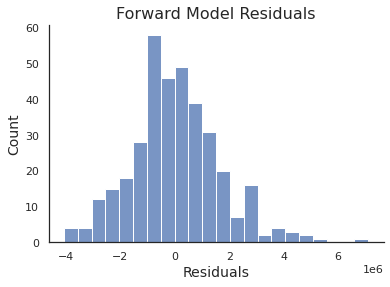

In [ ]:
sns.set(style = "white", color_codes = True)
sns.histplot(df['residuals'])
sns.despine(bottom = False, left = False)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Forward Model Residuals", fontsize = 16)
plt.savefig('fwd_residuals_hist.jpeg', bbox_inches='tight')

In [ ]:
df['CAP HIT'].dtypes

dtype('int64')

In [ ]:
df['pred_cap'].dtypes

dtype('float64')

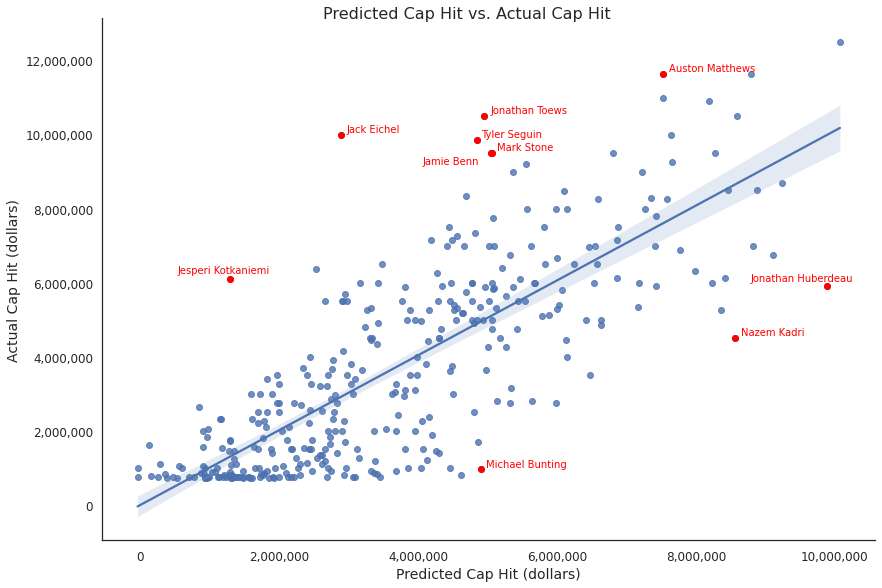

In [ ]:
# plot actual cap hit vs predicted cap hit
sns.set(style = "white", color_codes = True)
p =sns.lmplot(x='pred_cap', y='CAP HIT', data=df, height=8.27, aspect=11.7/8.27)

plt.ticklabel_format(style='plain', axis='y')
#plt.title(label='Predicted Cap Hit vs. Actual Cap Hit', x=0.5, y=1.1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
p.fig.suptitle("Predicted Cap Hit vs. Actual Cap Hit", fontsize=16, fontdict={"weight": "bold"})
p.set_axis_labels( "Predicted Cap Hit (dollars)" , "Actual Cap Hit (dollars)" , size = 14)

# add labels for names of players with highest residuals
plt.text(df.pred_cap[df.PLAYER_clean=='Jack Eichel']+75000,df['CAP HIT'][df.PLAYER_clean=='Jack Eichel']+75000,"Jack Eichel", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Jonathan Toews']+85000,df['CAP HIT'][df.PLAYER_clean=='Jonathan Toews']+75000,"Jonathan Toews", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Tyler Seguin']+50000,df['CAP HIT'][df.PLAYER_clean=='Tyler Seguin']+75000,"Tyler Seguin", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Jesperi Kotkaniemi']-750000,df['CAP HIT'][df.PLAYER_clean=='Jesperi Kotkaniemi']+150000,"Jesperi Kotkaniemi", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Mark Stone']+85000,df['CAP HIT'][df.PLAYER_clean=='Mark Stone']+75000,"Mark Stone", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Jamie Benn']-1000000,df['CAP HIT'][df.PLAYER_clean=='Jamie Benn']-300000,"Jamie Benn", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Auston Matthews']+75000,df['CAP HIT'][df.PLAYER_clean=='Auston Matthews']+75000,"Auston Matthews", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Nazem Kadri']+75000,df['CAP HIT'][df.PLAYER_clean=='Nazem Kadri']+75000,"Nazem Kadri", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Jonathan Huberdeau']-1100000,df['CAP HIT'][df.PLAYER_clean=='Jonathan Huberdeau']+150000,"Jonathan Huberdeau", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Michael Bunting']+75000,df['CAP HIT'][df.PLAYER_clean=='Michael Bunting']+75000,"Michael Bunting", color='red', size = 10)
plt.scatter(df_hr['pred_cap'], df_hr['CAP HIT'], color="red")


#plt.scatter(df_lr['pred_cap'], df_lr['CAP HIT'], color="green")


for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('CAPHITvsPred_CAPHIT.jpeg', bbox_inches='tight')

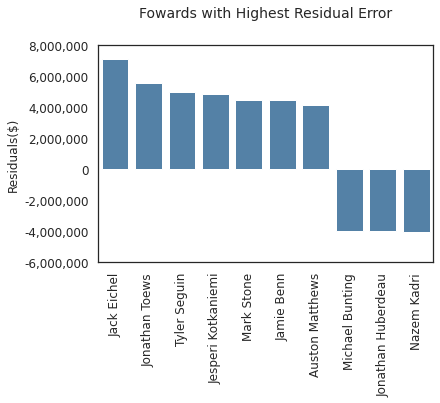

In [ ]:
#fig, ax = plt.subplots()

p = sns.barplot(x='PLAYER_clean', y='residuals', data=df_hr, color='steelblue')
plt.xticks(rotation=90, fontsize = 12)
plt.yticks(np.arange(-6000000, 8000001, 2000000), fontsize=12)
#plt.ticklabel_format(style='plain', axis='y')
#p.set(title='Fowards with Highest Residual Error', xlabel='Player',  ylabel = 'Residuals($)')
plt.title(label='Fowards with Highest Residual Error', size = 14, x=0.5, y=1.1)
p.set(xlabel=None)
plt.ylabel('Residuals($)', size = 12)
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('foward_high_residuals.jpeg', bbox_inches='tight')

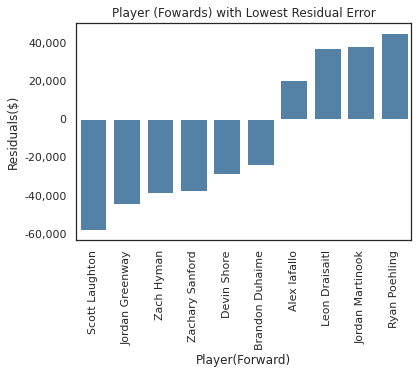

In [ ]:
fig, ax = plt.subplots()

p = sns.barplot(x='PLAYER_clean', y='residuals', data=df_lr, color='steelblue')
plt.xticks(rotation=90)
plt.ticklabel_format(style='plain', axis='y')
p.set(title='Player (Fowards) with Lowest Residual Error', xlabel='Player(Forward)', ylabel = 'Residuals($)')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

plt.savefig('foward_low_residuals.jpeg', bbox_inches='tight')

In [ ]:
# R-squared
# print('RF_base Training R Squared : ', rf2.score(X_train_scaled, y_train))
# print('RF_base Test R Squared : ', rf2.score(X_test_scaled, y_test))
# print('\n')
# print('RF_PCA Training R Squared : ', rf3.score(X_train_scaled_pca, y_train))
# print('RF_PCA Test R Squared : ', rf3.score(X_test_scaled_pca, y_test))
# print('\n')
# print('RF_PCA_GS Training R Squared : ', rf4.score(X_train_scaled_pca, y_train))
# print('RF_PCA_GS Test R Squared : ', rf4.score(X_test_scaled_pca, y_test))

In [ ]:
# Evaluating the Algorithm
# from sklearn import metrics
# print('Baseline Random Forest:')  
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred))  
# print('MSE:', metrics.mean_squared_error(y_test, y_pred))  
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print('\n')
# print('PCA Random Forest:')
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred_pca))  
# print('MSE:', metrics.mean_squared_error(y_test, y_pred_pca))  
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_pca)))
# print('\n')
# print('PCA Random Forest with Hyperparameter tuning:')
# print('MAE:', metrics.mean_absolute_error(y_test, y_pred_gs))  
# print('MSE:', metrics.mean_squared_error(y_test, y_pred_gs))  
# print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_gs)))

# Defensemen

In [ ]:
'''
load in defensemen file and distinguish target variable (CAP HIT)
'''

INFILE = "/content/Final_Project_Data_Defensemen_standard.csv"

TARGET_A = "CAP HIT"

df = pd.read_csv( INFILE )

## Data Cleaning

In [ ]:
'''
data cleaning
'''
# check data types
df.dtypes

# drop rows with NA values
df = df.dropna()

# convert salary to integer using string manipulation and astype command
df['SALARY'] = df['SALARY'].str.replace(',', '')
df['SALARY'] = df['SALARY'].str.replace('$', '')
df['SALARY'] = df['SALARY'].astype(int)

# convert cap hit to integer using string manipulation and astype command
df['CAP HIT'] = df['CAP HIT'].str.replace(',', '')
df['CAP HIT'] = df['CAP HIT'].str.replace('$', '')
df['CAP HIT'] = df['CAP HIT'].astype(int)

# one hot encode handedness
df['HANDED_L'] = df.HANDED.str.count('Left')
df['HANDED_R'] = df.HANDED.str.count('Right')

# convert TOI to seconds
# split TOI by ':' to minutes and seconds columns
# defensemen were recorded to milliseconds, so have to split those as well 
df[['minutes', 'seconds','milliseconds']] = df['TOI'].str.split(pat = ':', expand = True)

# convert minutes and seconds columns to integers
# no defensemen had values in milliseconds so can ignore column
df['minutes'] = df['minutes'].astype(int)
df['seconds'] = df['seconds'].astype(int)

# multiply minutes by 60 then add to seconds for total TOI in seconds
df['TOI_S'] = df['minutes']*60 + df['seconds']

# create avg TOI in minutes variable
df['TOI_M'] = df['minutes'] + df['seconds']/60

# create total minutes played during the season
df['Tot_MinPlayed'] = df['TOI_M'] * df['GP']

# drop original 'POS', 'HANDED', 'PLAYER', 'TOI', 'minutes', 'seconds', 'TYPE' columns
df = df.drop(columns = ['HANDED', 'PLAYER', 'TOI', 'minutes', 'seconds','TYPE', 'milliseconds']).reset_index(drop=True)

df.head(10)

PLAYER_clean  AGE POS  GP   G   A   P  P/GP  +/-   Sh  Sh%   ixG  iSh  \
0     Erik Karlsson   32  RD  50  10  25  35  0.70  -14  117 0.09  6.79  117   
1      Drew Doughty   32  RD  39   7  24  31  0.79    4   99 0.07  5.45   99   
2  Zachary Werenski   24  LD  68  11  37  48  0.71  -15  216 0.05 12.22  216   
3    Charlie McAvoy   24  RD  78  10  46  56  0.72   31  166 0.06  8.82  166   
4          Adam Fox   24  RD  78  11  63  74  0.95   18  158 0.07  8.49  158   
5        Seth Jones   27  RD  78   5  46  51  0.65  -37  194 0.03  9.39  194   
6     Darnell Nurse   27  LD  71   9  26  35  0.49   18  203 0.04 10.26  203   
7        Roman Josi   32  LD  80  23  73  96  1.20   13  281 0.08 15.57  281   
8   Dougie Hamilton   29  RD  62   9  21  30  0.48  -19  197 0.05 10.84  197   
9        Cale Makar   23  RD  77  28  58  86  1.12   48  240 0.12 13.33  240   

   iCF  iFF  ixG60  iSh60  iCF60  iFF60       SF       SA   SF%       CF  \
0  248  170   0.35   5.98  12.68   8.69   697.00   611.00 53.29 1,247.00   
1  183  127   0.33   5.92  10.94   7.59   615.00   434.00 58.63 1,092.00   
2  428  313   0.42   7.43  14.72  10.76   999.00   982.00 50.43 1,902.00   
3  295  227   0.28   5.18   9.21   7.09 1,312.00   897.00 59.39 2,136.00   
4  275  197   0.27   5.08   8.85   6.34 1,016.00   866.00 53.99 1,798.00   
5  365  255   0.28   5.69  10.71   7.48 1,072.00 1,013.00 51.41 1,921.00   
6  410  286   0.35   6.85  13.83   9.65 1,027.00 1,020.00 50.17 1,803.00   
7  563  385   0.46   8.25  16.52  11.30 1,228.00 1,028.00 54.43 2,264.00   
8  402  285   0.49   8.98  18.32  13.00   798.00   667.00 54.47 1,469.00   
9  494  319   0.40   7.29  15.00   9.68 1,349.00   933.00 59.11 2,387.00   

        CA   CF%       FF       FA   FF%    xGF    xGA  xGF%   CAP HIT  \
0 1,118.00 52.73   955.00   838.00 53.26  67.50  67.97 49.83  11500000   
1   769.00 58.68   831.00   592.00 58.40  59.52  48.65 55.02  11000000   
2 1,654.00 53.49 1,423.00 1,305.00 52.16  98.04  96.15 50.49   9583333   
3 1,628.00 56.75 1,718.00 1,212.00 58.63 121.49  82.31 59.61   9500000   
4 1,638.00 52.33 1,398.00 1,228.00 53.24 108.58  85.70 55.89   9500000   
5 1,830.00 51.21 1,419.00 1,350.00 51.25  96.24  99.63 49.13   9500000   
6 1,753.00 50.70 1,388.00 1,372.00 50.29 106.51 100.60 51.43   9250000   
7 1,821.00 55.42 1,709.00 1,386.00 55.22 122.19  98.45 55.38   9059000   
8 1,183.00 55.39 1,115.00   905.00 55.20  73.02  66.67 52.27   9000000   
9 1,628.00 59.45 1,809.00 1,249.00 59.16 138.99  88.90 60.99   9000000   

     SALARY  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  
0  12000000         0         1   1408  23.47       1,173.33  
1  11000000         0         1   1544  25.73       1,003.60  
2  10000000         1         0   1539  25.65       1,744.20  
3   9250000         0         1   1479  24.65       1,922.70  
4  11000000         0         1   1434  23.90       1,864.20  
5  10000000         0         1   1572  26.20       2,043.60  
6  12000000         1         0   1502  25.03       1,777.37  
7   9750000         1         0   1533  25.55       2,044.00  
8   6300000         0         1   1273  21.22       1,315.43  
9   9000000         0         1   1540  25.67       1,976.33

In [ ]:
duplicateRows = df[df.duplicated(['PLAYER_clean'])]
duplicateRows

Empty DataFrame
Columns: [PLAYER_clean, AGE, POS, GP, G, A, P, P/GP, +/-, Sh, Sh%, ixG, iSh, iCF, iFF, ixG60, iSh60, iCF60, iFF60, SF, SA, SF%, CF, CA, CF%, FF, FA, FF%, xGF, xGA, xGF%, CAP HIT, SALARY, HANDED_L, HANDED_R, TOI_S, TOI_M, Tot_MinPlayed]
Index: []

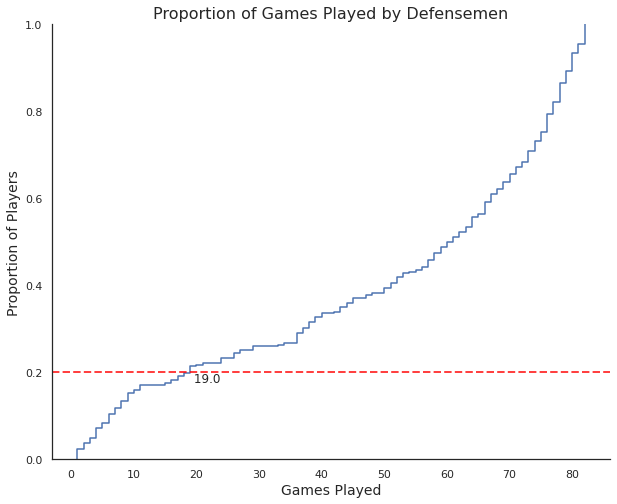

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="GP")
y_special = 0.2
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='red', lw=2, alpha=0.75)
plt.xlabel('Games Played', fontsize = 14)
plt.ylabel('Proportion of Players', fontsize = 14)
ax.set_title('Proportion of Games Played by Defensemen', fontdict={'fontsize':16, 'fontweight': 'medium'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
# drop players with less than 19 games played (lower 20%) which is about 1/4 of the season
df = df[df['GP']>=19]

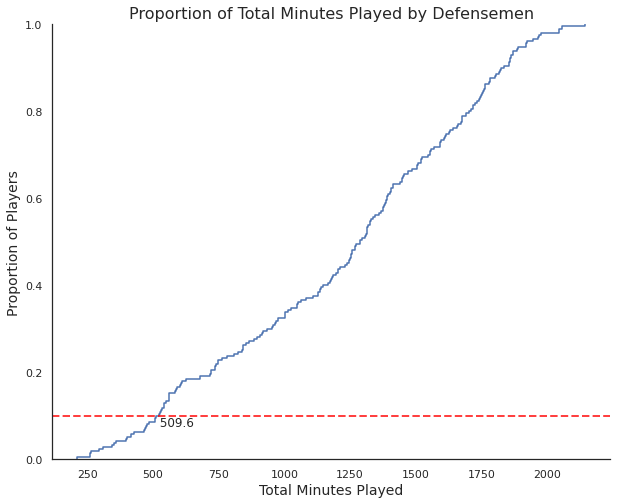

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
sns.ecdfplot(data=df, x="Tot_MinPlayed")
y_special = 0.1
for line in ax.get_lines():
    x, y = line.get_data()
    ind = np.argwhere(y >= y_special)[0, 0]  # first index where y is larger than y_special
    # x[ind] is the desired x-value
    ax.text(x[ind], y_special, f' {x[ind]:.1f}', ha='left', va='top') # maybe color=line.get_color()
ax.axhline(y_special, linestyle='--', color='red', lw=2, alpha=0.75)
plt.xlabel('Total Minutes Played', fontsize = 14)
plt.ylabel('Proportion of Players', fontsize = 14)
ax.set_title('Proportion of Total Minutes Played by Defensemen', fontdict={'fontsize':16, 'fontweight': 'medium'})
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [ ]:
# drop players with less than 509.6 total minutes played during the season
df = df[df['Tot_MinPlayed']>=509.6]
len(df.index)

189

In [ ]:
# check POS values
df['POS'].value_counts()

RD       81
LD       62
LD/RD    46
Name: POS, dtype: int64

In [ ]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder()

#perform one-hot encoding on 'POS' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['POS']]).toarray())

encoder_df.columns = encoder.get_feature_names_out()

#merge one-hot encoded columns back with original DataFrame
df = df.reset_index(drop=True)
df = df.join(encoder_df)

In [ ]:
# create stats by game played
df['G/GP'] = df['G']/df['GP']
df['A/GP'] = df['A']/df['GP']
df['plusminus/GP'] = df['+/-']/df['GP']
df['Sh/GP'] = df['Sh']/df['GP']

# create stats by minute played
df['G/Min'] = df['G']/df['Tot_MinPlayed']
df['A/Min'] = df['A']/df['Tot_MinPlayed']
df['plusminus/Min'] = df['+/-']/df['Tot_MinPlayed']
df['Sh/Min'] = df['Sh']/df['Tot_MinPlayed']
df['P/Min'] = df['P']/df['Tot_MinPlayed']

# drop variables not needed for modeling
model_df = df.drop(columns = ['PLAYER_clean', 'POS', 'GP', 'G', 'A', 'P', '+/-', 'Sh', 'SALARY'])

model_df.head()

AGE  P/GP  Sh%   ixG  iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60       SF  \
0   32  0.70 0.09  6.79  117  248  170   0.35   5.98  12.68   8.69   697.00   
1   32  0.79 0.07  5.45   99  183  127   0.33   5.92  10.94   7.59   615.00   
2   24  0.71 0.05 12.22  216  428  313   0.42   7.43  14.72  10.76   999.00   
3   24  0.72 0.06  8.82  166  295  227   0.28   5.18   9.21   7.09 1,312.00   
4   24  0.95 0.07  8.49  158  275  197   0.27   5.08   8.85   6.34 1,016.00   

      SA   SF%       CF       CA   CF%       FF       FA   FF%    xGF   xGA  \
0 611.00 53.29 1,247.00 1,118.00 52.73   955.00   838.00 53.26  67.50 67.97   
1 434.00 58.63 1,092.00   769.00 58.68   831.00   592.00 58.40  59.52 48.65   
2 982.00 50.43 1,902.00 1,654.00 53.49 1,423.00 1,305.00 52.16  98.04 96.15   
3 897.00 59.39 2,136.00 1,628.00 56.75 1,718.00 1,212.00 58.63 121.49 82.31   
4 866.00 53.99 1,798.00 1,638.00 52.33 1,398.00 1,228.00 53.24 108.58 85.70   

   xGF%   CAP HIT  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  POS_LD  \
0 49.83  11500000         0         1   1408  23.47       1,173.33    0.00   
1 55.02  11000000         0         1   1544  25.73       1,003.60    0.00   
2 50.49   9583333         1         0   1539  25.65       1,744.20    1.00   
3 59.61   9500000         0         1   1479  24.65       1,922.70    0.00   
4 55.89   9500000         0         1   1434  23.90       1,864.20    0.00   

   POS_LD/RD  POS_RD  G/GP  A/GP  plusminus/GP  Sh/GP  G/Min  A/Min  \
0       0.00    1.00  0.20  0.50         -0.28   2.34   0.01   0.02   
1       0.00    1.00  0.18  0.62          0.10   2.54   0.01   0.02   
2       0.00    0.00  0.16  0.54         -0.22   3.18   0.01   0.02   
3       0.00    1.00  0.13  0.59          0.40   2.13   0.01   0.02   
4       0.00    1.00  0.14  0.81          0.23   2.03   0.01   0.03   

   plusminus/Min  Sh/Min  P/Min  
0          -0.01    0.10   0.03  
1           0.00    0.10   0.03  
2          -0.01    0.12   0.03  
3           0.02    0.09   0.03  
4           0.01    0.08   0.04

## Correlation Matrix Heatmap

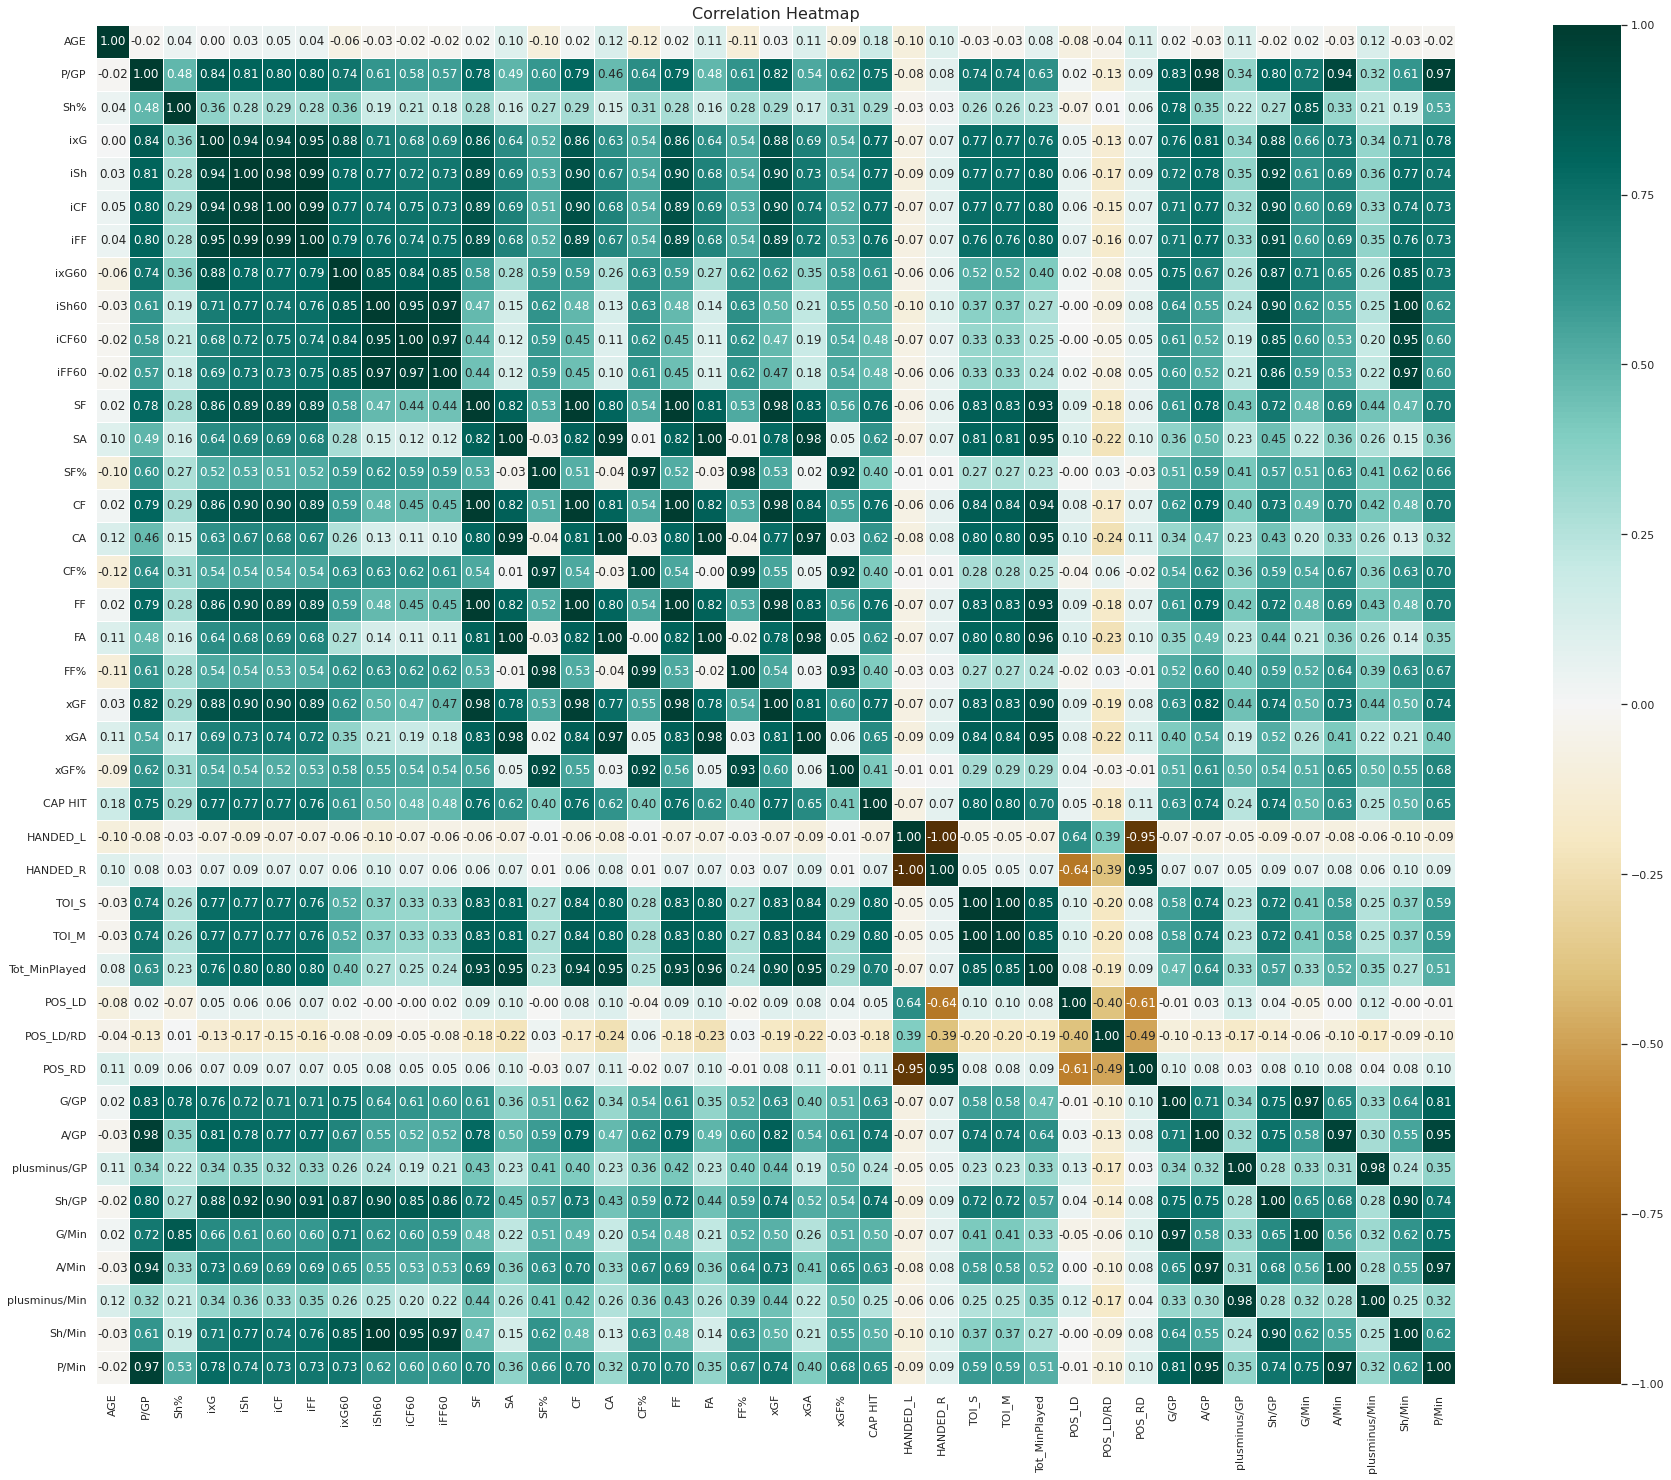

In [ ]:
# creating correlation heatmap to determine potential predictor variables
corr_mat = model_df.corr()
f, ax = plt.subplots(figsize=(35, 25))
sns.heatmap(corr_mat, vmin=-1, vmax=1, annot=True, square=True, linewidths=.5, cmap='BrBG', fmt='.2f')
plt.title('Correlation Heatmap', size = 16)

plt.savefig('CorrHeatmap.pdf', bbox_inches='tight')
plt.savefig('CorrHeatmap.jpeg', bbox_inches='tight')

## Models

### Regression

#### Feature Selection

In [ ]:
 # the independent variables set
X = model_df.drop([TARGET_A, 'HANDED_L', 'HANDED_R', 'POS_RD', 'POS_LD', 'POS_LD/RD', 'TOI_S' ,'TOI_M', 'Tot_MinPlayed'], axis=1 )

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
vif_data = vif_data.sort_values(by=['VIF'], ascending=False)  
print(vif_data)

len(vif_data)

          feature          VIF
31          P/Min          inf
28          A/Min          inf
27          G/Min          inf
8           iSh60 1,161,785.34
30         Sh/Min 1,157,791.85
19            FF%   104,669.91
17             FF    38,585.73
16            CF%    38,067.69
13            SF%    33,598.43
18             FA    33,560.29
1            P/GP    24,854.38
24           A/GP    15,710.89
12             SA    13,648.69
14             CF    13,541.22
11             SF    12,731.25
15             CA    10,118.94
6             iFF     6,911.78
10          iFF60     5,052.72
22           xGF%     4,752.86
4             iSh     4,171.33
5             iCF     3,968.17
9           iCF60     3,591.48
23           G/GP     1,780.98
21            xGA     1,600.53
20            xGF     1,450.95
26          Sh/GP       606.27
3             ixG       492.94
7           ixG60       443.53
2             Sh%        93.72
0             AGE        88.21
25   plusminus/GP        57.94
29  plus

32

In [ ]:
Y = df[ [TARGET_A] ]

In [ ]:
# feature selection
select = SelectKBest(score_func=r_regression, k=10)
z = select.fit_transform(X,Y)

# diplay selected variables
filter = select.get_support()
print(X.columns[filter])

Index(['P/GP', 'ixG', 'iSh', 'iCF', 'iFF', 'SF', 'CF', 'FF', 'xGF', 'Sh/GP'], dtype='object')


In [ ]:
select2 = SelectKBest(score_func=f_regression, k=10)
f = select2.fit_transform(X,Y)

# diplay selected variables
filter2 = select2.get_support()
print(X.columns[filter2])

Index(['P/GP', 'ixG', 'iSh', 'iCF', 'iFF', 'SF', 'CF', 'FF', 'xGF', 'Sh/GP'], dtype='object')


In [ ]:
select3 = SelectKBest(score_func=mutual_info_regression, k=10)
m = select3.fit_transform(X,Y)

# diplay selected variables
filter3 = select3.get_support()
print(X.columns[filter3])

Index(['P/GP', 'ixG', 'iSh', 'iCF', 'iFF', 'SF', 'CF', 'CA', 'FF', 'xGF'], dtype='object')


In [ ]:
# reduced set of final predictor varaibles to use in model
X_red = X[['P/GP', 'Sh/GP', 'CA']]

In [ ]:
# check VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X_red.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_red.values, i)
                          for i in range(len(X_red.columns))]
vif_data = vif_data.sort_values(by=['VIF'], ascending=False)  
print(vif_data)

  feature   VIF
1   Sh/GP 16.24
0    P/GP 10.22
2      CA  7.62


#### Train/Test Split

In [ ]:
'''
create training and test data sets
'''
# setting random state to 2 for now so we can repeat results
X_train, X_test, Y_train, Y_test = train_test_split(X_red, Y, train_size = 0.8, test_size = 0.2, random_state = 2)

#### Multiple Linear Regression

In [ ]:
'''
regression with SelectKBest feature selection
'''
WHO = "REG_KBEST"

# amount lost given loan defaults (linear regression)
AMT = LinearRegression()
AMT = AMT.fit( X_train, Y_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, X_train, Y_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, X_test, Y_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

varNames = list( X_train.columns.values )

# call function from above to grab coefficents
REG_KBEST_AMT_COEF = getCoefLinear( AMT, X_train )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(X_train, Y_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(X_test, Y_test[TARGET_A]))

# save results for comparison with other models
REG_KBEST_AMT = TEST_AMT.copy()

#predictions 
y_pred_mlr = AMT.predict(X_test)
rmse_mlr = math.sqrt(np.round(mean_squared_error(Y_test, y_pred_mlr), 2))
r2_mlr = np.round(r2_score(Y_test, y_pred_mlr), 3)

REG_KBEST RMSE ACCURACY
REG_KBEST_Train  =  1427256.0877853988
REG_KBEST  =  1489827.30415048
------



Coefficients
---------
Total Variables:  4
INTERCEPT  =  -2056664.5126592573
P/GP  =  4575816.816932221
Sh/GP  =  1246056.1474023426
CA  =  1671.502665318083
Training R Squared :  0.6689624629497706
Test R Squared :  0.7230159219037957


#### Ridge Regression

In [ ]:
# Ridge regression
from sklearn.linear_model import Ridge

WHO = "RIDGE"

ridge = Ridge()
ridge = ridge.fit(X_train, Y_train[TARGET_A])
                          
TRAIN_ridge = getAmtAccuracyScores( WHO + "_Train", ridge, X_train, Y_train[TARGET_A] )
TEST_ridge = getAmtAccuracyScores( WHO, ridge, X_test, Y_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_ridge, TEST_ridge ] )

varNames = list( X_train.columns.values )

# call function from above to grab coefficents
RIDGE_COEF = getCoefLinear( ridge, X_train )

# print R squared vale of model on training data
print('Training R Squared : ', ridge.score(X_train, Y_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', ridge.score(X_test, Y_test[TARGET_A]))

# save results for comparison with other models
REG_RIDGE_AMT = TEST_ridge.copy()

# create table of results
y_pred_ridge = ridge.predict(X_test)
rmse_ridge = math.sqrt(np.round(mean_squared_error(Y_test, y_pred_ridge), 2))
r2_ridge = np.round(r2_score(Y_test, y_pred_ridge), 3)

df_results = pd.DataFrame([[rmse_mlr, r2_mlr], [rmse_ridge, r2_ridge]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression', 'Ridge Regression'])

df_results

RIDGE RMSE ACCURACY
RIDGE_Train  =  1436213.2881739074
RIDGE  =  1469651.9340889368
------



Coefficients
---------
Total Variables:  4
INTERCEPT  =  -2224412.1921098568
P/GP  =  3219495.0163484807
Sh/GP  =  1562115.929378665
CA  =  1803.1870669905943
Training R Squared :  0.664794361634041
Test R Squared :  0.7304670109483369


RMSE  R-Squared
Linear Regression 1,489,827.30       0.72
Ridge Regression  1,469,651.93       0.73

### Random Forest Models

#### Train/Test Split

In [ ]:
''' create new test and train data set with all variables for RF and GB models '''

W = model_df.copy()
W = W.drop([TARGET_A, 'HANDED_L', 'HANDED_R', 'POS_RD', 'POS_LD', 'POS_LD/RD', 'TOI_S' ,'TOI_M', 'Tot_MinPlayed'], axis=1 )

Z = model_df[ [TARGET_A] ]

W_train, W_test, Z_train, Z_test = train_test_split(W, Z, train_size=0.8, test_size=0.2, random_state=2)

#### Random Forest

In [ ]:
''' create RF model '''

WHO = "RF"

# create random forest regressor and fit to data
AMT = RandomForestRegressor(n_estimators = 100, random_state=2)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by RF
feature_cols = list( W.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by RF and their weights
for i in vars_RF_amt :
    print( i )

# save results for comparison with other models later
RF_AMT = TEST_AMT.copy()

# add results to table
y_pred_rf = AMT.predict(W_test)
rmse_rf = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_rf), 2))
r2_rf = np.round(r2_score(Z_test, y_pred_rf), 3)


df_rf = pd.DataFrame([[rmse_rf, r2_rf]],
                           columns = ['RMSE', 'R-Squared'], index = ['Random Forest'])

df_results = df_results.append(df_rf)

df_results

RF RMSE ACCURACY
RF_Train  =  593483.3088449428
RF  =  1741142.0459103147
------


('P/GP', 100)
('iSh', 77)
('CF', 42)
('A/GP', 38)
('ixG', 38)
('iCF', 33)
('Sh/GP', 31)
('iFF', 31)
('AGE', 20)
('SF', 18)


RMSE  R-Squared
Linear Regression 1,489,827.30       0.72
Ridge Regression  1,469,651.93       0.73
Random Forest     1,741,142.05       0.62

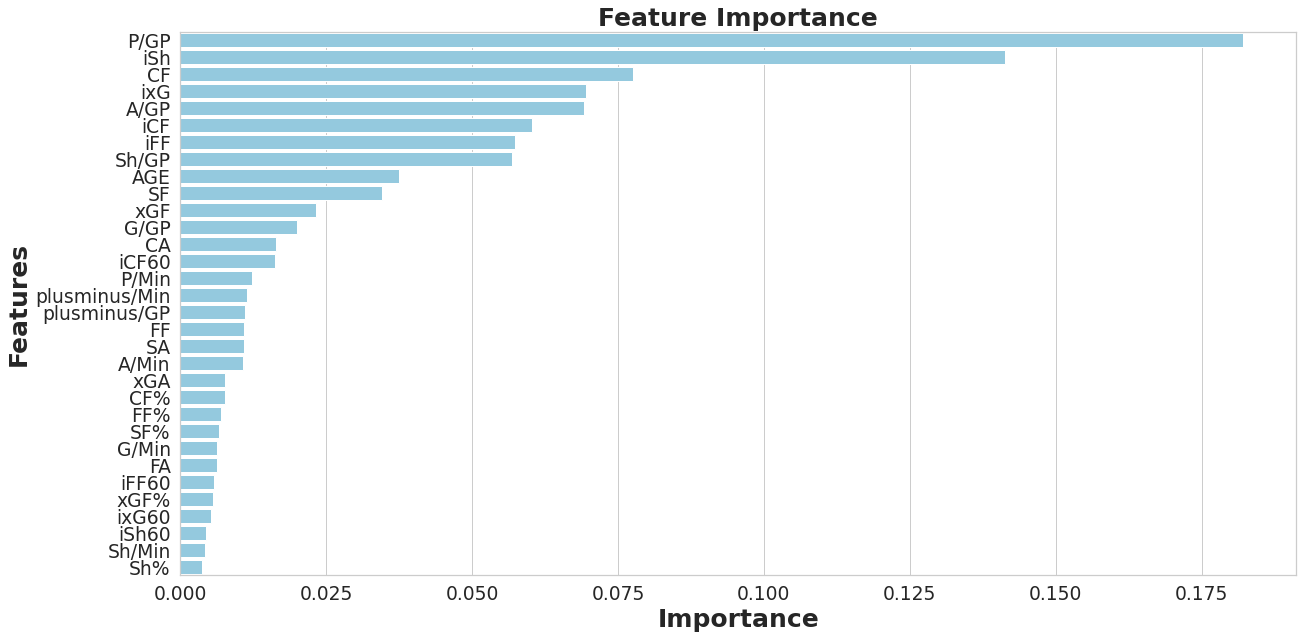

None

Features  Gini-Importance
0            P/GP             0.18
1             iSh             0.14
2              CF             0.08
3             ixG             0.07
4            A/GP             0.07
5             iCF             0.06
6             iFF             0.06
7           Sh/GP             0.06
8             AGE             0.04
9              SF             0.03
10            xGF             0.02
11           G/GP             0.02
12             CA             0.02
13          iCF60             0.02
14          P/Min             0.01
15  plusminus/Min             0.01
16   plusminus/GP             0.01
17             FF             0.01
18             SA             0.01
19          A/Min             0.01
20            xGA             0.01
21            CF%             0.01
22            FF%             0.01
23            SF%             0.01
24          G/Min             0.01
25             FA             0.01
26          iFF60             0.01
27           xGF%             0.01
28          ixG60             0.01
29          iSh60             0.00
30         Sh/Min             0.00
31            Sh%             0.00

In [ ]:
RF = RandomForestRegressor(n_estimators = 100, random_state=2)
RF = RF.fit( W_train, Z_train[TARGET_A] )

# get feature importance
feats = {}
for feature, importance in zip(W_train.columns, RF.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

#### Grandient Boosted Machine

In [ ]:
''' create GB model '''

WHO = "GB"

# create gradient boosting regressor and fit to data
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by GB
feature_cols = list( W.columns.values )
vars_GB_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by GB and their weights
for i in vars_GB_amt :
    print( i )

# save results for comparison with other models later on
GB_CLM = TEST_AMT.copy()

# add results to table
y_pred_gb = AMT.predict(W_test)
rmse_gb = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_gb), 2))
r2_gb = np.round(r2_score(Z_test, y_pred_gb), 3)


df_gb = pd.DataFrame([[rmse_gb, r2_gb]],
                           columns = ['RMSE', 'R-Squared'], index = ['Gradient Boosted RF'])

df_results = df_results.append(df_gb)

df_results

GB RMSE ACCURACY
GB_Train  =  199980.46631668482
GB  =  1753149.31210516
------


('iSh', 100)
('P/GP', 28)
('ixG', 24)
('AGE', 14)
('A/GP', 12)
('xGF', 10)
('CA', 10)
('CF', 10)


RMSE  R-Squared
Linear Regression   1,489,827.30       0.72
Ridge Regression    1,469,651.93       0.73
Random Forest       1,741,142.05       0.62
Gradient Boosted RF 1,753,149.31       0.62

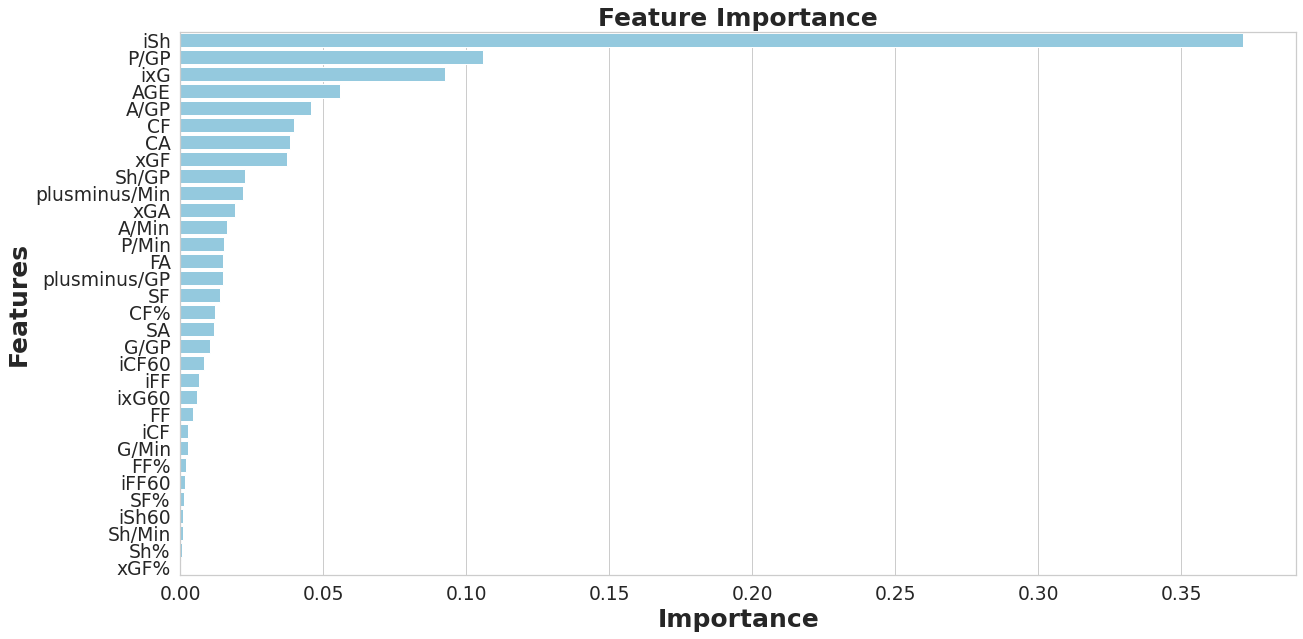

None

Features  Gini-Importance
0             iSh             0.37
1            P/GP             0.11
2             ixG             0.09
3             AGE             0.06
4            A/GP             0.05
5              CF             0.04
6              CA             0.04
7             xGF             0.04
8           Sh/GP             0.02
9   plusminus/Min             0.02
10            xGA             0.02
11          A/Min             0.02
12          P/Min             0.02
13             FA             0.02
14   plusminus/GP             0.01
15             SF             0.01
16            CF%             0.01
17             SA             0.01
18           G/GP             0.01
19          iCF60             0.01
20            iFF             0.01
21          ixG60             0.01
22             FF             0.00
23            iCF             0.00
24          G/Min             0.00
25            FF%             0.00
26          iFF60             0.00
27            SF%             0.00
28          iSh60             0.00
29         Sh/Min             0.00
30            Sh%             0.00
31           xGF%             0.00

In [ ]:
GB = GradientBoostingRegressor(random_state=1)
GB = GB.fit( W_train, Z_train[TARGET_A] )

# get feature importance
feats = {}
for feature, importance in zip(W_train.columns, GB.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

#### Regression with RF/GB variables

In [ ]:
''' run regression with RF/GB variables '''

WHO = "REG_RF_VARS"


# since RF variables are extracted with weights attached, need to run through loop that only takes variable names
print("\n\n")
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append( theVar )

# create regression model with vars selected by RF and GB models
AMT = LinearRegression()
AMT = AMT.fit( W_train[RF_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[RF_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[RF_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# call function from above to grab coefficents
REG_RF_AMT_COEF = getCoefLinear( AMT, W_train[RF_amt] )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(W_train[RF_amt], Z_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(W_test[RF_amt], Z_test[TARGET_A]))

# save results for comparison with other models
REG_RF_AMT = TEST_AMT.copy()

# add results to table
y_pred_mlr2 = AMT.predict(W_test[RF_amt])
rmse_mlr2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_mlr2), 2))
r2_mlr2 = np.round(r2_score(Z_test, y_pred_mlr2), 3)


df_mlr2 = pd.DataFrame([[rmse_mlr2, r2_mlr2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression with RF Variables'])

df_results = df_results.append(df_mlr2)

df_results




('P/GP', 100)
('iSh', 77)
('CF', 42)
('A/GP', 38)
('ixG', 38)
('iCF', 33)
('Sh/GP', 31)
('iFF', 31)
('AGE', 20)
('SF', 18)
REG_RF_VARS RMSE ACCURACY
REG_RF_VARS_Train  =  1349171.9317176223
REG_RF_VARS  =  1465443.245795474
------



Coefficients
---------
Total Variables:  11
INTERCEPT  =  -7240308.424339874
P/GP  =  -1476932.8233951898
iSh  =  -17604.983958873236
CF  =  4784.976859340168
A/GP  =  4003855.0330011295
ixG  =  161947.2835231382
iCF  =  1433.2840484397566
Sh/GP  =  2889593.8557938915
iFF  =  -16924.36860373529
AGE  =  169214.52477995105
SF  =  -2098.890728542223
Training R Squared :  0.7041932847193659
Test R Squared :  0.7320085406523344


RMSE  R-Squared
Linear Regression                   1,489,827.30       0.72
Ridge Regression                    1,469,651.93       0.73
Random Forest                       1,741,142.05       0.62
Gradient Boosted RF                 1,753,149.31       0.62
Linear Regression with RF Variables 1,465,443.25       0.73

#### Regression with RF Variabales (reduced)

In [ ]:
# create regression model with vars selected by RF and GB models
# remove var with negative coefficient and lowest weight
Red_amt = ['P/GP', 'CF', 'AGE', 'A/GP', 'ixG', 'iSh']

AMT = LinearRegression()
AMT = AMT.fit( W_train[Red_amt], Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train[Red_amt], Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test[Red_amt], Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# call function from above to grab coefficents
REG_RF_AMT_COEF = getCoefLinear( AMT, W_train[Red_amt] )

# print R squared vale of model on training data
print('Training R Squared : ', AMT.score(W_train[Red_amt], Z_train[TARGET_A]))
# print R squared vale of model on test data
print('Test R Squared : ', AMT.score(W_test[Red_amt], Z_test[TARGET_A]))

# save results for comparison with other models
REG_RF_AMT2 = TEST_AMT.copy()

y_pred_mlr2 = AMT.predict(W_test[Red_amt])
rmse_mlr2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_mlr2), 2))
r2_mlr2 = np.round(r2_score(Z_test, y_pred_mlr2), 3)


df_mlr2 = pd.DataFrame([[rmse_mlr2, r2_mlr2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Linear Regression with RF Variables (Reduced)'])

df_results = df_results.append(df_mlr2)

df_results

REG_RF_VARS RMSE ACCURACY
REG_RF_VARS_Train  =  1430212.2332120321
REG_RF_VARS  =  1606625.6387195631
------



Coefficients
---------
Total Variables:  7
INTERCEPT  =  -4531200.315553413
P/GP  =  3556713.1930348026
CF  =  1249.6028185410796
AGE  =  140276.1272648481
A/GP  =  1294860.276921174
ixG  =  108748.09559720744
iSh  =  5536.715915557108
Training R Squared :  0.6675897470833034
Test R Squared :  0.6778839736982109


RMSE  R-Squared
Linear Regression                             1,489,827.30       0.72
Ridge Regression                              1,469,651.93       0.73
Random Forest                                 1,741,142.05       0.62
Gradient Boosted RF                           1,753,149.31       0.62
Linear Regression with RF Variables           1,465,443.25       0.73
Linear Regression with RF Variables (Reduced) 1,606,625.64       0.68

#### RF Hyperparameter Tuning

In [ ]:
# hyperparameter tuning using randomizedsearchCV
# from sklearn.model_selection import RandomizedSearchCV

AMT = RandomForestRegressor(random_state=2)
AMT = AMT.fit( W_train, Z_train[TARGET_A] )

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
#bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
rs = RandomizedSearchCV(AMT, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=2)

rs.fit(W_train, Z_train[TARGET_A])
rs.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 700,
#  'min_samples_split': 12,
#  'min_samples_leaf': 2,
#  'max_features': 'log2',
#  'max_depth': 11}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 700,
 'min_samples_split': 12,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11}

In [ ]:
# get dataframe of RandomSearchCV results
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                700                      12                      2   
1                900                      23                      2   
2               1000                       7                      7   
3                700                       2                      7   
4                200                       7                      7   
5                200                       2                      7   
6                600                      18                      7   
7                500                      28                      7   
8                600                      28                      7   
9                200                      23                      7   

  param_max_features param_max_depth  mean_test_score  rank_test_score  
0               log2              11             0.57                1  
1               sqrt               6             0.57                2  
2               log2               8             0.57                3  
3               sqrt              15             0.57                4  
4               sqrt              10             0.57                5  
5               log2               6             0.57                5  
6               sqrt              12             0.57                7  
7               sqrt              11             0.57                8  
8               sqrt               2             0.56                9  
9               log2              15             0.56               10

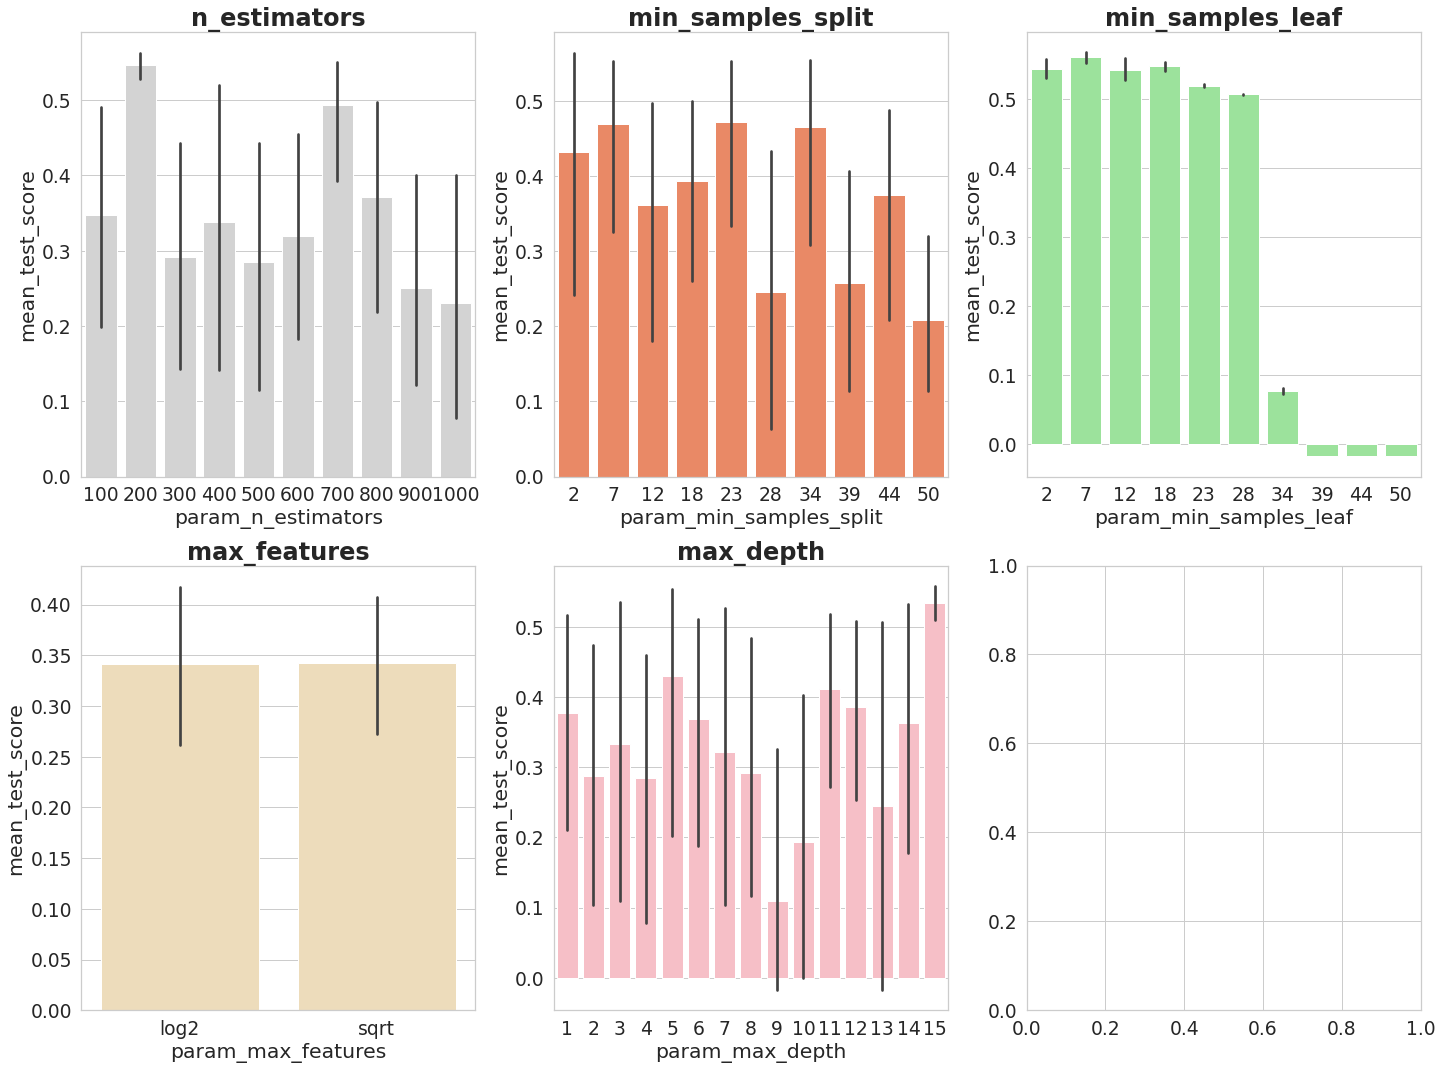

In [ ]:
# create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(24,18)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_title(label = 'n_estimators', weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_split', weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_title(label = 'min_samples_leaf', weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_title(label = 'max_depth', weight='bold')

plt.show()

In [ ]:
# fine tune hyperparameters using gridsearchCV
# from sklearn.model_selection import GridSearchCV

# AMT = RandomForestRegressor(random_state=2)
# AMT = AMT.fit( W_train, Z_train[TARGET_A] )

# n_estimators = [200, 700]
# max_features = ['log2','sqrt']
# max_depth = [5,11,12,15]
# min_samples_split = [7,23,34]
# min_samples_leaf = [2,7,12,18,23]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}
# gs = GridSearchCV(AMT, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(W_train, Z_train[TARGET_A])
# rf_ht = gs.best_estimator_
# gs.best_params_

# Fitting 3 folds for each of 450 candidates, totalling 1350 fits
# {'max_depth': 5,
#  'max_features': 'log2',
#  'min_samples_leaf': 2,
#  'min_samples_split': 23,
#  'n_estimators': 700}

In [ ]:
WHO = "RF_HT"

# create RF regressor and fit to data
AMT = RandomForestRegressor(random_state=2, max_depth=5,
                                max_features= 'log2',
                                min_samples_leaf= 2,
                                min_samples_split=23,
                                n_estimators= 700)

AMT = AMT.fit( W_train, Z_train[TARGET_A] )

TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, W_train, Z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, W_test, Z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

# extract and save variables selected by RF
feature_cols = list( W.columns.values )
vars_RF_amt = getEnsembleTreeVars( AMT, feature_cols )

# print variables selected by RF and their weights
for i in vars_RF_amt :
    print( i )

# save results for comparison with other models later on
RF_HT = TEST_AMT.copy()

y_pred_rf2 = AMT.predict(W_test)
rmse_rf2 = math.sqrt(np.round(mean_squared_error(Z_test, y_pred_rf2), 2))
r2_rf2 = np.round(r2_score(Z_test, y_pred_rf2), 3)


df_rf2 = pd.DataFrame([[rmse_rf2, r2_rf2]],
                           columns = ['RMSE', 'R-Squared'], index = ['Random Forest (Hyperparameter Tuning)'])

df_results = df_results.append(df_rf2)

df_results

RF_HT RMSE ACCURACY
RF_HT_Train  =  1217516.9576768782
RF_HT  =  1683122.4112491463
------


('iSh', 100)
('P/GP', 91)
('ixG', 75)
('A/GP', 66)
('xGF', 65)
('Sh/GP', 62)
('iFF', 61)
('SF', 60)
('CF', 60)
('iCF', 55)
('FF', 53)


RMSE  R-Squared
Linear Regression                             1,489,827.30       0.72
Ridge Regression                              1,469,651.93       0.73
Random Forest                                 1,741,142.05       0.62
Gradient Boosted RF                           1,753,149.31       0.62
Linear Regression with RF Variables           1,465,443.25       0.73
Linear Regression with RF Variables (Reduced) 1,606,625.64       0.68
Random Forest (Hyperparameter Tuning)         1,683,122.41       0.65

#### RF with PCA Transformation

In [ ]:
#from sklearn.preprocessing import StandardScaler
 
ss = StandardScaler()
 
# separate the independent and dependent variables
# X_data = model_df.drop(columns = ['CAP HIT'])
# target = model_df['CAP HIT']
 
# standardization of dependent variables 

X_train_scaled = ss.fit_transform(W_train)
X_test_scaled = ss.transform(W_test)
y_train = np.array(Z_train)
y_test = np.array(Z_test)

In [ ]:
# create baseline RF

rf2 = RandomForestRegressor(random_state=2)
rf2 = rf2.fit(X_train_scaled, y_train)
rf2.score(X_train_scaled, y_train)

0.9429115048013835

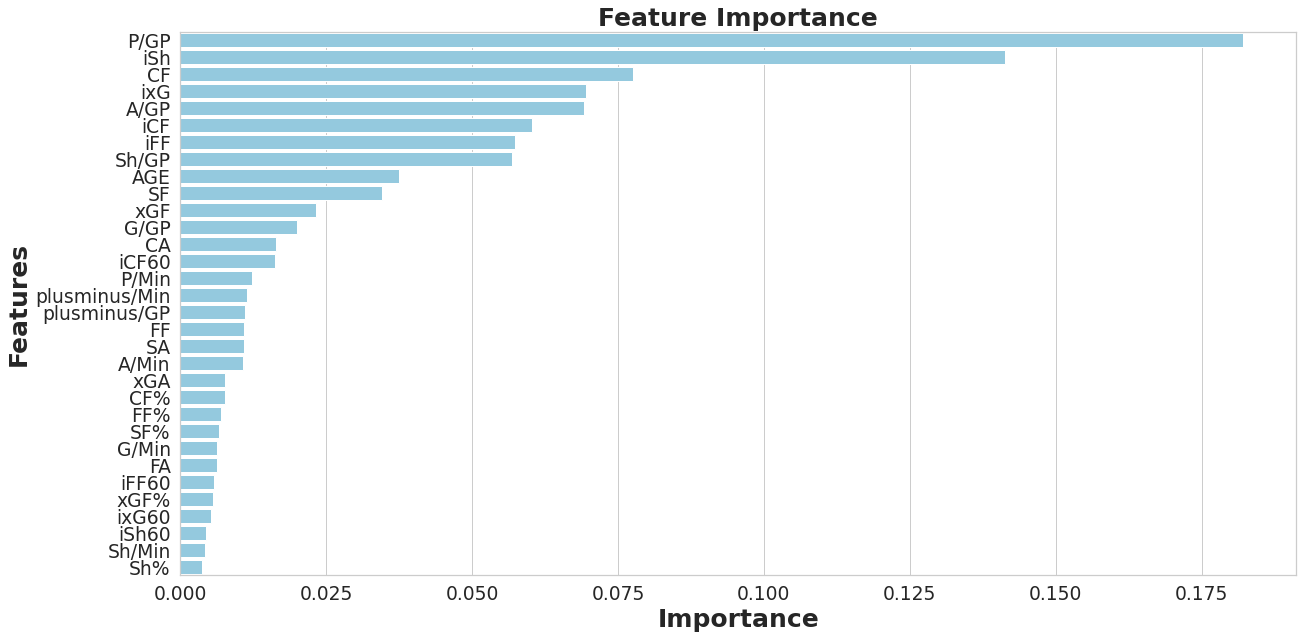

None

Features  Gini-Importance
0            P/GP             0.18
1             iSh             0.14
2              CF             0.08
3             ixG             0.07
4            A/GP             0.07
5             iCF             0.06
6             iFF             0.06
7           Sh/GP             0.06
8             AGE             0.04
9              SF             0.03
10            xGF             0.02
11           G/GP             0.02
12             CA             0.02
13          iCF60             0.02
14          P/Min             0.01
15  plusminus/Min             0.01
16   plusminus/GP             0.01
17             FF             0.01
18             SA             0.01
19          A/Min             0.01
20            xGA             0.01
21            CF%             0.01
22            FF%             0.01
23            SF%             0.01
24          G/Min             0.01
25             FA             0.01
26          iFF60             0.01
27           xGF%             0.01
28          ixG60             0.01
29          iSh60             0.00
30         Sh/Min             0.00
31            Sh%             0.00

In [ ]:
# get feature importance
feats = {}
for feature, importance in zip(X.columns, rf2.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-Importance'})
importances = importances.sort_values(by='Gini-Importance', ascending=False)
importances = importances.reset_index()
importances = importances.rename(columns={'index': 'Features'})
sns.set(font_scale = 5)
sns.set(style="whitegrid", color_codes=True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.barplot(x=importances['Gini-Importance'], y=importances['Features'], data=importances, color='skyblue')
plt.xlabel('Importance', fontsize=25, weight = 'bold')
plt.ylabel('Features', fontsize=25, weight = 'bold')
plt.title('Feature Importance', fontsize=25, weight = 'bold')
display(plt.show())
display(importances)

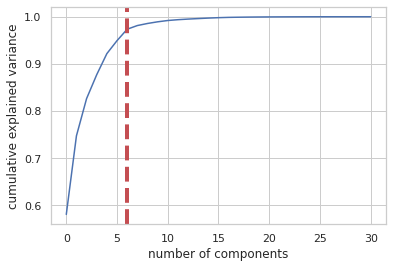

None

Cumulative Variance Ratio  Explained Variance Ratio
0                        0.58                      0.58
1                        0.75                      0.17
2                        0.83                      0.08
3                        0.88                      0.05
4                        0.92                      0.04
5                        0.95                      0.03
6                        0.97                      0.02
7                        0.98                      0.01
8                        0.99                      0.00
9                        0.99                      0.00
10                       0.99                      0.00
11                       0.99                      0.00
12                       1.00                      0.00
13                       1.00                      0.00
14                       1.00                      0.00

In [ ]:
# create plot to determine number of compenents to use for PCA
#from sklearn.decomposition import PCA

pca_test = PCA(n_components=31)
pca_test.fit(X_train_scaled)
sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=6, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(15))

# based on the below output I chose 6 components since that explains about 97% of the variance and there isn't a drastic improvement after that

In [ ]:
# PCA transformation
pca = PCA(n_components=6)
pca.fit(X_train_scaled)
X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)

In [ ]:
# display table of components
pca_dims = []
for x in range(0, len(pca_df)):
    pca_dims.append('PCA Component {}'.format(x))
pca_test_df = pd.DataFrame(pca_test.components_, columns=X.columns, index=pca_dims)
pca_test_df.head(6).T

PCA Component 0  PCA Component 1  PCA Component 2  \
AGE                       0.01            -0.04            -0.02   
P/GP                      0.21             0.00            -0.04   
Sh%                       0.11             0.02            -0.18   
ixG                       0.22            -0.05             0.09   
iSh                       0.22            -0.06             0.12   
iCF                       0.22            -0.07             0.12   
iFF                       0.22            -0.06             0.13   
ixG60                     0.19             0.14             0.17   
iSh60                     0.17             0.20             0.25   
iCF60                     0.17             0.20             0.26   
iFF60                     0.17             0.21             0.27   
SF                        0.21            -0.16            -0.10   
SA                        0.14            -0.34             0.02   
SF%                       0.15             0.24            -0.22   
CF                        0.21            -0.16            -0.08   
CA                        0.13            -0.35             0.02   
CF%                       0.16             0.24            -0.19   
FF                        0.21            -0.16            -0.09   
FA                        0.14            -0.35             0.02   
FF%                       0.16             0.25            -0.20   
xGF                       0.21            -0.14            -0.10   
xGA                       0.15            -0.32             0.06   
xGF%                      0.15             0.21            -0.28   
G/GP                      0.19             0.05             0.00   
A/GP                      0.20            -0.02            -0.06   
plusminus/GP              0.10             0.02            -0.40   
Sh/GP                     0.21             0.06             0.20   
G/Min                     0.18             0.10            -0.02   
A/Min                     0.19             0.04            -0.08   
plusminus/Min             0.11             0.02            -0.39   
Sh/Min                    0.17             0.20             0.25   
P/Min                     0.21             0.06            -0.07   

               PCA Component 3  PCA Component 4  PCA Component 5  
AGE                      -0.38            -0.21             0.84  
P/GP                     -0.03             0.27             0.14  
Sh%                      -0.53             0.27            -0.26  
ixG                      -0.01            -0.00            -0.04  
iSh                       0.03            -0.07            -0.00  
iCF                       0.03            -0.06             0.00  
iFF                       0.03            -0.08             0.00  
ixG60                    -0.06            -0.04            -0.09  
iSh60                    -0.02            -0.17            -0.01  
iCF60                    -0.02            -0.16            -0.02  
iFF60                    -0.00            -0.18            -0.01  
SF                        0.13            -0.02            -0.00  
SA                        0.01            -0.05            -0.06  
SF%                       0.20            -0.00             0.03  
CF                        0.12            -0.01            -0.00  
CA                        0.00            -0.07            -0.05  
CF%                       0.19             0.04             0.01  
FF                        0.13            -0.02            -0.00  
FA                        0.01            -0.06            -0.06  
FF%                       0.20             0.00             0.01  
xGF                       0.11            -0.01             0.02  
xGA                       0.01            -0.03            -0.03  
xGF%                      0.16            -0.02            -0.02  
G/GP                     -0.35             0.16            -0.12  
A/GP                      0.08             0.29             0.21  
plusminus/GP             -0.

In [ ]:
# refit xgb random forest model using PCA transformation
rf3 = RandomForestRegressor(random_state=2)
rf3 = rf3.fit(X_train_scaled_pca, y_train)

In [ ]:
print('Training R Squared : ', rf3.score(X_train_scaled_pca, y_train))

Training R Squared :  0.9519009320075222


In [ ]:
y_pred_pca = rf3.predict(X_test_scaled_pca)
rmse_pca = math.sqrt(np.round(mean_squared_error(y_test, y_pred_pca), 2))
r2_pca = np.round(r2_score(y_test, y_pred_pca), 3)


df_pca = pd.DataFrame([[rmse_pca, r2_pca]],
                           columns = ['RMSE', 'R-Squared'], index = ['RF with PCA'])

df_results = df_results.append(df_pca)

df_results

RMSE  R-Squared
Linear Regression                             1,489,827.30       0.72
Ridge Regression                              1,469,651.93       0.73
Random Forest                                 1,741,142.05       0.62
Gradient Boosted RF                           1,753,149.31       0.62
Linear Regression with RF Variables           1,465,443.25       0.73
Linear Regression with RF Variables (Reduced) 1,606,625.64       0.68
Random Forest (Hyperparameter Tuning)         1,683,122.41       0.65
RF with PCA                                   1,977,605.09       0.51

#### RF PCA Hyperparameter

In [ ]:
# hyperparameter tuning using randomizedsearchCV
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rs = RandomizedSearchCV(rf3, 
                        param_dist, 
                        n_iter = 100, 
                        cv = 3, 
                        verbose = 1, 
                        n_jobs=-1, 
                        random_state=2)

rs.fit(X_train_scaled_pca, y_train)
rs.best_params_


# Fitting 3 folds for each of 100 candidates, totalling 300 fits
# {'n_estimators': 300,
#  'min_samples_split': 2,
#  'min_samples_leaf': 2,
#  'max_features': 'log2',
#  'max_depth': 12,
#  'bootstrap': True}

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 12,
 'bootstrap': True}

In [ ]:
# get dataframe of RandomSearchCV results
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

param_n_estimators param_min_samples_split param_min_samples_leaf  \
0                300                       2                      2   
1                200                       2                      2   
2                900                       2                      2   
3                700                      12                      2   
4                600                      23                      2   
5                200                       2                      7   
6               1000                       7                      7   
7                700                       2                      7   
8                500                       2                     12   
9                900                      34                      2   

  param_max_features param_max_depth param_bootstrap  mean_test_score  \
0               log2              12            True             0.53   
1               log2              14            True             0.52   
2               log2              13           False             0.52   
3               log2              11            True             0.51   
4               log2               7           False             0.48   
5               log2              14           False             0.48   
6               log2               8            True             0.47   
7               sqrt              15            True             0.46   
8               log2               5           False             0.45   
9               log2              14           False             0.44   

   rank_test_score  
0                1  
1                2  
2                3  
3                4  
4                5  
5                6  
6                7  
7                8  
8                9  
9               10

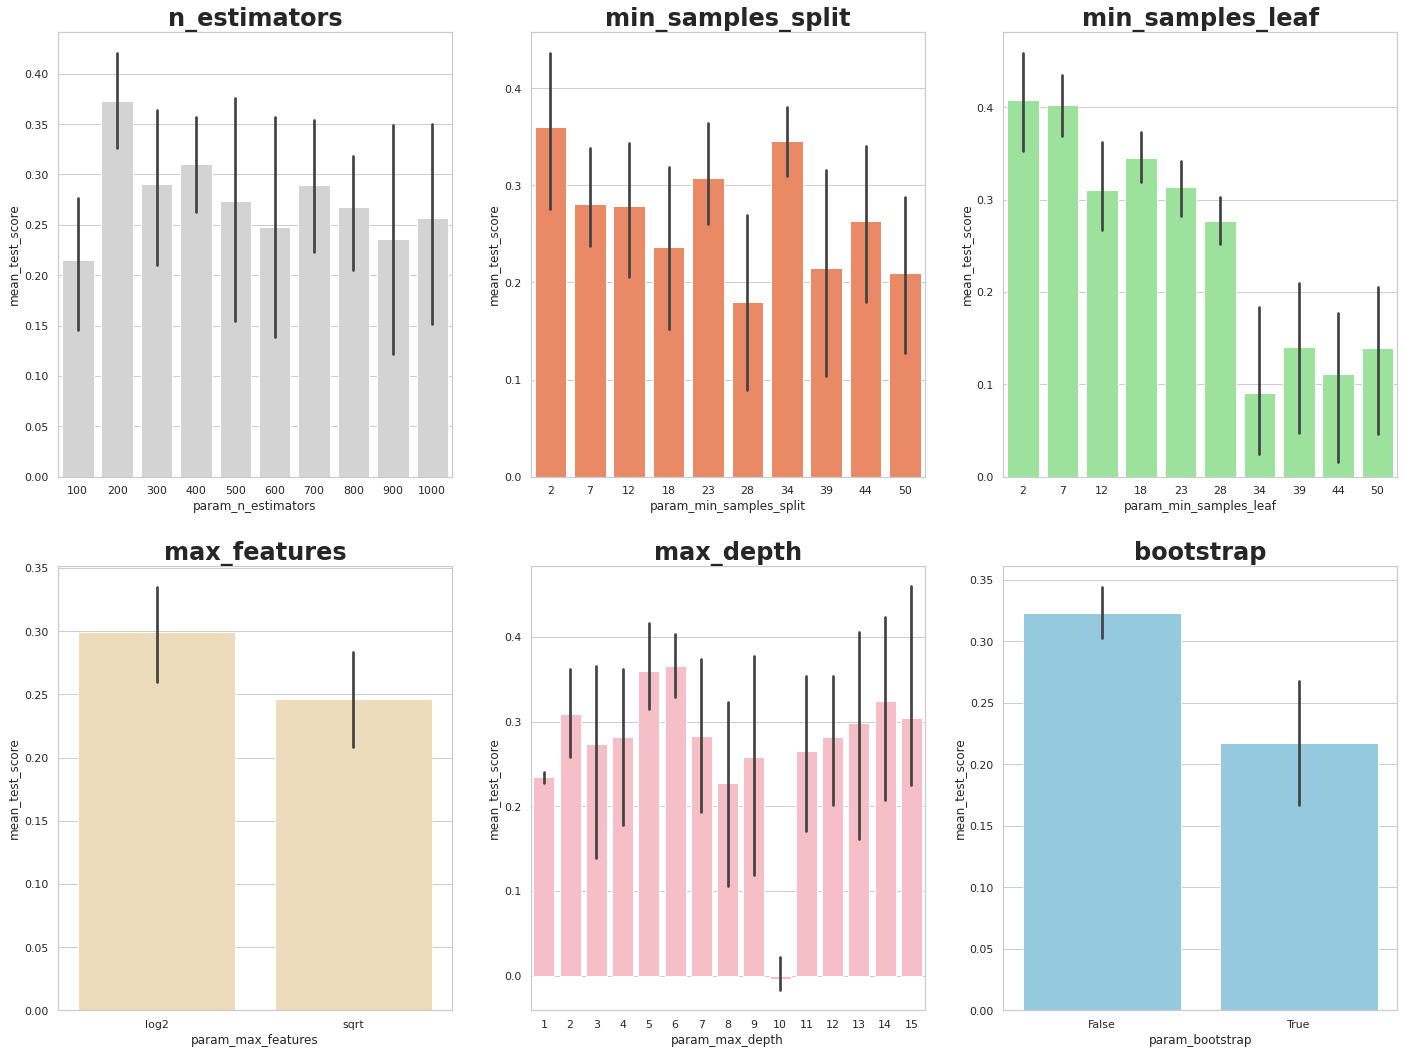

In [ ]:
# create bar plots of each hyperparameter on the x-axis, and the mean score of the models made at each value, to see which values were most successful on average

fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(24,18)

sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_title(label = 'n_estimators', weight='bold')

sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_title(label = 'min_samples_split', weight='bold')

sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_title(label = 'min_samples_leaf', weight='bold')

sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_title(label = 'max_features', weight='bold')

sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_title(label = 'max_depth', weight='bold')

sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_title(label = 'bootstrap', weight='bold')

plt.show()

In [ ]:
''' this section is commented out because it takes a 5-10 to run, but it is used to fine tune the hyperparameters. I've hard-coded the results below and passed these parameters to the rf4 model'''

# fine tune hyperparameters using gridsearchCV
# from sklearn.model_selection import GridSearchCV

# n_estimators = [200, 400]
# max_features = ['log2']
# max_depth = [5,6,14]
# min_samples_split = [2,23,34]
# min_samples_leaf = [2,3,4,5,6,7]
# bootstrap = [False]
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# gs = GridSearchCV(rf3, param_grid, cv = 3, verbose = 1, n_jobs=-1)
# gs.fit(X_train_scaled_pca, y_train)
# rf4 = gs.best_estimator_
# gs.best_params_

# Fitting 3 folds for each of 108 candidates, totalling 324 fits
# {'bootstrap': False,
#  'max_depth': 14,
#  'max_features': 'log2',
#  'min_samples_leaf': 2,
#  'min_samples_split': 2,
#  'n_estimators': 400}

" this section is commented out because it takes a 5-10 to run, but it is used to fine tune the hyperparameters. I've hard-coded the results below and passed these parameters to the rf4 model"

In [ ]:
# tune hyperparameters using the results from the above gridsearchCV
rf4 = RandomForestRegressor(bootstrap=False, max_depth=14, max_features='log2',
                            min_samples_leaf=2, min_samples_split=2, n_estimators=400)
rf4 = rf4.fit(X_train_scaled_pca, y_train)

In [ ]:
y_pred_pca2 = rf4.predict(X_test_scaled_pca)
rmse_pca2 = math.sqrt(np.round(mean_squared_error(y_test, y_pred_pca2), 2))
r2_pca2 = np.round(r2_score(y_test, y_pred_pca2), 3)


df_pca2 = pd.DataFrame([[rmse_pca2, r2_pca2]],
                           columns = ['RMSE', 'R-Squared'], index = ['RF with PCA (Hyperparameter Tuning)'])

df_results = df_results.append(df_pca2)

df_results

RMSE  R-Squared
Linear Regression                             1,489,827.30       0.72
Ridge Regression                              1,469,651.93       0.73
Random Forest                                 1,741,142.05       0.62
Gradient Boosted RF                           1,753,149.31       0.62
Linear Regression with RF Variables           1,465,443.25       0.73
Linear Regression with RF Variables (Reduced) 1,606,625.64       0.68
Random Forest (Hyperparameter Tuning)         1,683,122.41       0.65
RF with PCA                                   1,977,605.09       0.51
RF with PCA (Hyperparameter Tuning)           2,001,951.60       0.50

## Final Defensemen Model Results

In [ ]:
# create predicted CAP HIT for all players
df['pred_cap'] = ridge.predict(X_red)

In [ ]:
# create residuals and abs residuals
df['residuals'] = df['CAP HIT'] - df['pred_cap']
df['residuals_abs'] = df['residuals'].abs()

In [ ]:
# format cap hit
#df['CAP HIT'] = df['CAP HIT'].map('{:,.0f}'.format)

# create list of 10 players with highest residual error
df[['PLAYER_clean', 'CAP HIT', 'pred_cap', 'residuals','residuals_abs']].sort_values(by = 'residuals_abs', ascending=False).head(10)

PLAYER_clean   CAP HIT     pred_cap     residuals  residuals_abs
0          Erik Karlsson  11500000 5,700,548.73  5,799,451.27   5,799,451.27
1           Drew Doughty  11000000 5,671,010.93  5,328,989.07   5,328,989.07
22   Marc-Édouard Vlasic   7000000 1,765,921.62  5,234,078.38   5,234,078.38
90      MacKenzie Weegar   3250000 6,597,235.50 -3,347,235.50   3,347,235.50
188    Alexandre Carrier    733333 3,962,586.40 -3,229,253.40   3,229,253.40
3         Charlie McAvoy   9500000 6,353,715.90  3,146,284.10   3,146,284.10
25         Ryan McDonagh   6750000 3,783,347.42  2,966,652.58   2,966,652.58
19        Jared Spurgeon   7575000 4,620,493.66  2,954,506.34   2,954,506.34
71           Devon Toews   4100000 7,046,446.97 -2,946,446.97   2,946,446.97
11        Miro Heiskanen   8450000 5,659,496.59  2,790,503.41   2,790,503.41

In [ ]:
# subest dataframe to get players with highest abs residuals
df_hr = df.query('residuals_abs >=2790503.40').sort_values(by='residuals', ascending=False)
df_hr2 = df_hr[['PLAYER_clean', 'residuals']]
df_hr2

PLAYER_clean     residuals
0          Erik Karlsson  5,799,451.27
1           Drew Doughty  5,328,989.07
22   Marc-Édouard Vlasic  5,234,078.38
3         Charlie McAvoy  3,146,284.10
25         Ryan McDonagh  2,966,652.58
19        Jared Spurgeon  2,954,506.34
11        Miro Heiskanen  2,790,503.41
71           Devon Toews -2,946,446.97
188    Alexandre Carrier -3,229,253.40
90      MacKenzie Weegar -3,347,235.50

In [ ]:
df_hr

PLAYER_clean  AGE    POS  GP   G   A   P  P/GP  +/-   Sh  Sh%  \
0          Erik Karlsson   32     RD  50  10  25  35  0.70  -14  117 0.09   
1           Drew Doughty   32     RD  39   7  24  31  0.79    4   99 0.07   
22   Marc-Édouard Vlasic   35  LD/RD  75   3  11  14  0.19  -22   63 0.05   
3         Charlie McAvoy   24     RD  78  10  46  56  0.72   31  166 0.06   
25         Ryan McDonagh   33     LD  71   4  22  26  0.37   15   85 0.05   
19        Jared Spurgeon   32     RD  65  10  30  40  0.62   32  116 0.09   
11        Miro Heiskanen   22  LD/RD  70   5  31  36  0.51    3  156 0.03   
71           Devon Toews   28     LD  66  13  44  57  0.86   52  158 0.08   
188    Alexandre Carrier   25     RD  77   3  27  30  0.39   26   95 0.03   
90      MacKenzie Weegar   28  LD/RD  80   8  36  44  0.55   40  203 0.04   

      ixG  iSh  iCF  iFF  ixG60  iSh60  iCF60  iFF60       SF     SA   SF%  \
0    6.79  117  248  170   0.35   5.98  12.68   8.69   697.00 611.00 53.29   
1    5.45   99  183  127   0.33   5.92  10.94   7.59   615.00 434.00 58.63   
22   2.06   63  145   99   0.11   3.31   7.62   5.21   470.00 568.00 45.28   
3    8.82  166  295  227   0.28   5.18   9.21   7.09 1,312.00 897.00 59.39   
25   5.37   85  180  131   0.20   3.20   6.78   4.93   635.00 896.00 41.48   
19   6.34  116  234  157   0.28   5.05  10.21   6.85   825.00 635.00 56.51   
11  10.76  156  312  218   0.37   5.37  10.75   7.51   928.00 861.00 51.87   
71   8.47  158  267  202   0.30   5.66   9.57   7.24   994.00 881.00 53.01   
188  6.12   95  188  135   0.23   3.53   6.98   5.01   713.00 917.00 43.74   
90  10.02  203  391  271   0.32   6.51  12.55   8.69 1,143.00 985.00 53.71   

          CF       CA   CF%       FF       FA   FF%    xGF   xGA  xGF%  \
0   1,247.00 1,118.00 52.73   955.00   838.00 53.26  67.50 67.97 49.83   
1   1,092.00   769.00 58.68   831.00   592.00 58.40  59.52 48.65 55.02   
22    840.00 1,146.00 42.30   646.00   831.00 43.74  35.82 51.41 41.06   
3   2,136.00 1,628.00 56.75 1,718.00 1,212.00 58.63 121.49 82.31 59.61   
25  1,177.00 1,634.00 41.87   906.00 1,241.00 42.20  67.25 87.13 43.56   
19  1,460.00 1,143.00 56.09 1,117.00   871.00 56.19  82.96 65.61 55.84   
11  1,684.00 1,531.00 52.38 1,276.00 1,170.00 52.17  98.69 80.23 55.16   
71  1,743.00 1,532.00 53.22 1,304.00 1,178.00 52.54  96.19 78.47 55.07   
188 1,261.00 1,666.00 43.08   973.00 1,252.00 43.73  65.55 86.17 43.20   
90  1,992.00 1,712.00 53.78 1,520.00 1,292.00 54.05 115.77 99.76 53.71   

      CAP HIT    SALARY  HANDED_L  HANDED_R  TOI_S  TOI_M  Tot_MinPlayed  \
0    11500000  12000000         0         1   1408  23.47       1,173.33   
1    11000000  11000000         0         1   1544  25.73       1,003.60   
22    7000000   7250000         1         0    912  15.20       1,140.00   
3     9500000   9250000         0         1   1479  24.65       1,922.70   
25    6750000   5460000         1         0   1346  22.43       1,592.77   
19    7575000   6000000         0         1   1269  21.15       1,374.75   
11    8450000   7000000         1         0   1493  24.88       1,741.83   
71    4100000   4600000         1         0   1522  25.37       1,674.20   
188    733333    750000         0         1   1258  20.97       1,614.43   
90    3250000   4750000         0         1   1402  23.37       1,869.33   

     POS_LD  POS_LD/RD  POS_RD  G/GP  A/GP  plusminus/GP  Sh/GP  G/Min  A/Min  \
0      0.00       0.00    1.00  0.20  0.50         -0.28   2.34   0.01   0.02   
1      0.00       0.00    1.00  0.18  0.62          0.10   2.54   0.01   0.02   
22     0.00       1.00    0.00  0.04  0.15         -0.29   0.84   0.00   0.01   
3      0.00       0.00    1.00  0.13  0.59          0.40   2.13   0.01   0.02   
25     1.00       0.00    0.00  0.06  0.31          0.21   1.20   0.00   0.01   
19     0.00       0.00    1.00  0.15  0.46          0.49   1.78   0.01   0.02   
11     0.00       1.00    0.00  0.07  0.44          0.04   2.23   0.00   0.02   
71   

In [ ]:
# create list of 10 players with lowest residual error
df[['PLAYER_clean', 'CAP HIT', 'pred_cap', 'residuals','residuals_abs']].sort_values(by = 'residuals_abs', ascending=True).head(10)

PLAYER_clean  CAP HIT     pred_cap  residuals  residuals_abs
184      Kale Clague   750000   741,095.34   8,904.66       8,904.66
109     Adam Boqvist  2600000 2,583,088.94  16,911.06      16,911.06
107      Brett Kulak  2750000 2,727,062.17  22,937.83      22,937.83
156        Cal Foote   850000   818,810.92  31,189.08      31,189.08
148  Nicolas Meloche   950000   918,010.14  31,989.86      31,989.86
180     Simon Benoit   750000   785,530.81 -35,530.81      35,530.81
118  Jacob Middleton  2450000 2,487,556.10 -37,556.10      37,556.10
127     Niko Mikkola  1900000 1,861,585.50  38,414.50      38,414.50
126    Jérémy Lauzon  2000000 2,047,050.23 -47,050.23      47,050.23
134    Rasmus Sandin  1400000 1,455,648.64 -55,648.64      55,648.64

In [ ]:
df['P/GP'].describe()

count   189.00
mean      0.36
std       0.21
min       0.07
25%       0.20
50%       0.30
75%       0.44
max       1.20
Name: P/GP, dtype: float64

In [ ]:
df['Sh/GP'].describe()

count   189.00
mean      1.53
std       0.62
min       0.41
25%       1.05
50%       1.36
75%       1.91
max       3.51
Name: Sh/GP, dtype: float64

In [ ]:
df['CA'].describe()

count     189.00
mean    1,251.03
std       407.97
min       472.00
25%       933.00
50%     1,278.00
75%     1,591.00
max     2,263.00
Name: CA, dtype: float64

In [ ]:
# subest dataframe to get players with highest abs residuals
df_lr = df.query('residuals_abs <=55648.65').sort_values(by='residuals', ascending=True)

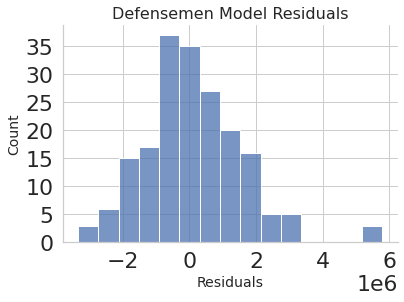

In [ ]:
sns.histplot(df['residuals'])
sns.set(style = "white", color_codes = True)
sns.despine(bottom = False, left = False)
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.title("Defensemen Model Residuals", fontsize = 16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('def_residuals_hist.jpeg', bbox_inches='tight')

In [ ]:
df_hr2

PLAYER_clean     residuals
0          Erik Karlsson  5,799,451.27
1           Drew Doughty  5,328,989.07
22   Marc-Édouard Vlasic  5,234,078.38
3         Charlie McAvoy  3,146,284.10
25         Ryan McDonagh  2,966,652.58
19        Jared Spurgeon  2,954,506.34
11        Miro Heiskanen  2,790,503.41
71           Devon Toews -2,946,446.97
188    Alexandre Carrier -3,229,253.40
90      MacKenzie Weegar -3,347,235.50

In [ ]:
df['CAP HIT'].dtype

dtype('int64')

In [ ]:
# df['pred_cap']=df['pred_cap'].astype('float')
# df['CAP HIT']=df['CAP HIT'].astype('float')

# df['pred_cap'].dtype

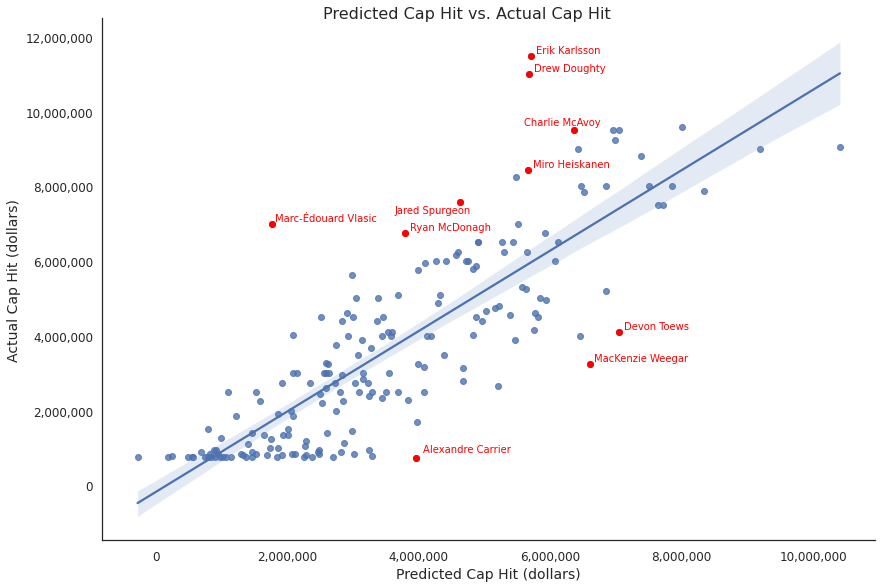

In [ ]:
# plot actual cap hit vs predicted cap hit
sns.set(style = "white", color_codes = True)
p =sns.lmplot(x='pred_cap', y='CAP HIT', data=df, height=8.27, aspect=11.7/8.27)

plt.ticklabel_format(style='plain', axis='y')
#plt.title(label='Predicted Cap Hit vs. Actual Cap Hit', x=0.5, y=1.1)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
p.fig.suptitle("Predicted Cap Hit vs. Actual Cap Hit", fontsize=16, fontdict={"weight": "bold"})
p.set_axis_labels( "Predicted Cap Hit (dollars)" , "Actual Cap Hit (dollars)" , size = 14)

# add labels for names of players with highest residuals
plt.text(df.pred_cap[df.PLAYER_clean=='Erik Karlsson']+75000,df['CAP HIT'][df.PLAYER_clean=='Erik Karlsson']+75000,"Erik Karlsson", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Drew Doughty']+85000,df['CAP HIT'][df.PLAYER_clean=='Drew Doughty']+75000,"Drew Doughty", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Marc-Édouard Vlasic']+50000,df['CAP HIT'][df.PLAYER_clean=='Marc-Édouard Vlasic']+75000,"Marc-Édouard Vlasic", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Charlie McAvoy']-750000,df['CAP HIT'][df.PLAYER_clean=='Charlie McAvoy']+150000,"Charlie McAvoy", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Ryan McDonagh']+85000,df['CAP HIT'][df.PLAYER_clean=='Ryan McDonagh']+75000,"Ryan McDonagh", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Jared Spurgeon']-1000000,df['CAP HIT'][df.PLAYER_clean=='Jared Spurgeon']-300000,"Jared Spurgeon", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Miro Heiskanen']+75000,df['CAP HIT'][df.PLAYER_clean=='Miro Heiskanen']+75000,"Miro Heiskanen", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Devon Toews']+75000,df['CAP HIT'][df.PLAYER_clean=='Devon Toews']+75000,"Devon Toews", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='Alexandre Carrier']+100000,df['CAP HIT'][df.PLAYER_clean=='Alexandre Carrier']+150000,"Alexandre Carrier", color='red', size = 10)
plt.text(df.pred_cap[df.PLAYER_clean=='MacKenzie Weegar']+75000,df['CAP HIT'][df.PLAYER_clean=='MacKenzie Weegar']+75000,"MacKenzie Weegar", color='red', size = 10)
plt.scatter(df_hr['pred_cap'], df_hr['CAP HIT'], color="red")


#plt.scatter(df_lr['pred_cap'], df_lr['CAP HIT'], color="green")





for ax in p.axes.flat:
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))



plt.savefig('CAPHITvsPred_CAPHIT_d.jpeg', bbox_inches='tight')

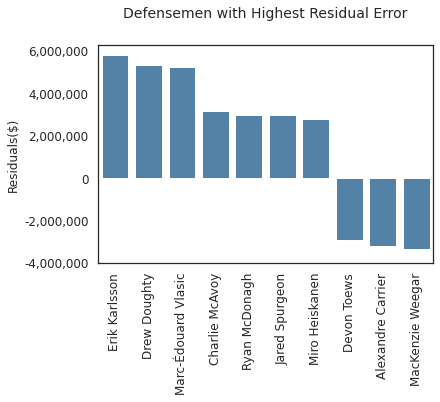

In [ ]:
p = sns.barplot(x='PLAYER_clean', y='residuals', data=df_hr, color='steelblue')
plt.xticks(rotation=90, fontsize = 12)
plt.yticks(np.arange(-4000000, 6000001, 2000000), fontsize=12)
#plt.ticklabel_format(style='plain', axis='y')
#p.set(title='Fowards with Highest Residual Error', xlabel='Player',  ylabel = 'Residuals($)')
plt.title(label='Defensemen with Highest Residual Error', size = 14, x=0.5, y=1.1)
p.set(xlabel=None)
plt.ylabel('Residuals($)', size = 12)
p.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('def_high_residuals.jpeg', bbox_inches='tight')